In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

df = pd.read_csv("flour_dataset.csv")

In [3]:
pid = 'Package ID'
gluten = 'Gluten Content (%)'
elasticity = 'Dough Elasticity Index'
dampening = 'Dampening Time (hours)'
weight = 'Package Weight (g)'
ash = 'Ash content (%)'
recipe = 'Production Recipe'
moisture = 'Moisture (%)'
starch = 'Starch Content (%)'
mill = 'Production Mill'
volume = 'Package Volume (cm3)'
proteins = 'Proteins (g)/100g'
color = 'Color'
quality = 'Quality'
unnamed = 'Unnamed: 14'

In [4]:
def clean_df(df):
    df_filtered = df[df.isnull().sum(1) == 1].drop(columns=[unnamed])
    outliers = (df_filtered[ash] > 10) | (df_filtered[dampening] < 0) | (df_filtered[elasticity] > 200) | (df_filtered[gluten] < 0)
    df_good = df_filtered[~outliers]
    return df_good

df = clean_df(df)

In [5]:
def stack_dict(inputs):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return tf.stack(values, axis=-1)

def sanitize_name(f):
    return "".join(x for x in f if x.isalnum())
    
def get_model(name, df, **kwargs):
    categorical_string_names = [
        'Production Mill',
    ]
    categorical_int_names = [
        'Production Recipe',
    ]

    numeric_feature_names = [
        #'Package ID',
        'Gluten Content (%)',
        'Dough Elasticity Index',
        'Dampening Time (hours)',
        'Package Weight (g)',
        'Ash content (%)',
        'Moisture (%)',
        'Starch Content (%)',
        'Package Volume (cm3)',
        'Proteins (g)/100g',
        'Color',
    ]
    if 'simple' in name:
        numeric_feature_names.remove('Package Volume (cm3)')
    if 'with_id' in name:
        numeric_feature_names.append('Package ID')
    if 'no_cat' in name:
        categorical_string_names.remove('Production Mill')
        categorical_int_names.remove('Production Recipe')
    categorical_feature_names = categorical_string_names + categorical_int_names

    numeric_features = df[numeric_feature_names]
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))

    inputs = {}
    for fname in df.keys():
        if fname in categorical_string_names:
            dtype = tf.string
            inputs[fname] = tf.keras.Input(shape=[], name=sanitize_name(fname), dtype=dtype)
        elif fname in categorical_int_names:
            dtype = tf.int64
            inputs[fname] = tf.keras.Input(shape=(), name=sanitize_name(fname), dtype=dtype)
        elif fname in numeric_feature_names:
            dtype = tf.float32
            inputs[fname] = tf.keras.Input(shape=(), name=sanitize_name(fname), dtype=dtype)
        else:
            print(f"Will ignore feature {fname}")
            continue

    numeric_inputs = {}
    for fname in numeric_feature_names:
        numeric_inputs[fname] = inputs[fname]
    
    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs)
    
    preprocessed = []
    preprocessed.append(numeric_normalized)

    for fname in categorical_feature_names:
        vocab = sorted(set(df[fname]))
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

        x = inputs[fname][:, tf.newaxis]
        x = lookup(x)
        preprocessed.append(x)

    preprocessed_result = tf.concat(preprocessed, axis=-1)
    preprocessor = tf.keras.Model(inputs, preprocessed_result)
    
    x = preprocessor(inputs)

    n_input = len(numeric_feature_names)+len(categorical_feature_names)
    hidden = tf.keras.layers.Dense(n_input, activation='relu')(x)
    dropout = kwargs.pop('dropout',False)
    deep    = kwargs.pop('deep',False)
    if dropout:
        hidden = tf.keras.layers.Dropout(.5, input_shape=(n_input,))(hidden)
    if deep:
        hidden = tf.keras.layers.Dense(n_input*2, activation='relu', **kwargs)(hidden)
        if dropout:
            hidden = tf.keras.layers.Dropout(.5, input_shape=(n_input*2,))(hidden)
        hidden = tf.keras.layers.Dense(n_input, activation='relu', **kwargs)(hidden)

    out1 = tf.keras.layers.Dense(1, activation='sigmoid', name='low_vs_avghigh')(hidden)
    out2 = tf.keras.layers.Dense(1, activation='sigmoid', name='lowavg_vs_high')(hidden)
        
    losses = {
        'low_vs_avghigh':'binary_crossentropy',
        'lowavg_vs_high':'binary_crossentropy',
             }

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2], name=name)
    model.compile(optimizer='adam',
                loss=losses,
                metrics=['accuracy'])
    model.summary()
    return model

model = get_model('test', df)

Metal device set to: Apple M2


2022-11-30 08:19:33.930530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 08:19:33.930984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-30 08:19:34.103809: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 08:19:34.178254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:19:34.222484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(N

In [15]:
def train_model(name, model, df, y, **kwargs):
    
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(patience=20, mode="min", restore_best_weights=True)) #, monitor="val_loss"))
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(f"checkpoints_{name}", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True,))
    # Terminate on NaN such that it is easier to debug
    callbacks.append(tf.keras.callbacks.TerminateOnNaN())
    
    opts = {'epochs':50, 'batch_size':32, 'verbose':0}
    opts.update(kwargs)

    history = model.fit(df, y, callbacks=callbacks, **opts)
    model.save(Path(name) / 'model')

    return history

def get_labels(df):
    target = df['Quality']
    target_names = ['Low','Average','High'] #set manually to keep this order
    target_labels = tf.keras.layers.StringLookup(vocabulary=target_names, output_mode='int')
    y = target_labels(target)-1
    y1 = tf.math.minimum(y,tf.constant([1], dtype=tf.int64))   #merge Avg+High
    y2 = tf.math.maximum(y,tf.constant([1], dtype=tf.int64))-1 #merge Low+Avg
    return [y1, y2]

def labels_to_class(y):
    y = tf.stack(y,axis=1)
    return tf.math.reduce_sum(y,axis=1)
    

In [16]:
from sklearn.model_selection import train_test_split

def resample_high(df, n):
    df_high = pd.concat([df[df['Quality']=='High']] * n)
    df_high = pd.concat([df,df_high ])
    return df_high


train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df = resample_high(train_df,20)

train_y = get_labels(train_df)
test_y  = get_labels(test_df)

#class_weights = {(0,0):1/39, (0,1):1/59, (1,1):1/2}

history = train_model('test', model, dict(train_df), train_y, 
                      validation_data=(dict(test_df), test_y),
                     )
                      #class_weight=class_weights)

INFO:tensorflow:Assets written to: test/model/assets


INFO:tensorflow:Assets written to: test/model/assets


In [24]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay as CMD

def validation_plots(name, history, model, test_df):

    plt.figure()
    plt.plot(history.history['low_vs_avghigh_loss'], label=f'train low vs avg+high')
    plt.plot(history.history['val_low_vs_avghigh_loss'], label=f'test low vs avg+high')
    plt.plot(history.history['lowavg_vs_high_loss'], label=f'train low+avg vs high')
    plt.plot(history.history['val_lowavg_vs_high_loss'], label=f'test low+avg vs high')

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.suptitle(name)
    plt.tick_params(right=True)

    plt.legend()
    plt.ylim([0,0.9])
    plt.savefig(Path(name) / 'losses.png')
    plt.show()
    plt.close()
    
    plt.figure()
    #plt.plot(tf.multiply(history.history['lowavg_vs_high_accuracy'],history.history['low_vs_avghigh_accuracy']), label=f'train both')
    #plt.plot(tf.multiply(history.history['val_lowavg_vs_high_accuracy'],history.history['val_low_vs_avghigh_accuracy']), label=f'test both')
    plt.plot(history.history['low_vs_avghigh_accuracy'], label=f'train low vs avg+high')
    plt.plot(history.history['val_low_vs_avghigh_accuracy'], label=f'test low vs avg+high')
    plt.plot(history.history['lowavg_vs_high_accuracy'], label=f'train low+avg vs high')
    plt.plot(history.history['val_lowavg_vs_high_accuracy'], label=f'test low+avg vs high')
    plt.tick_params(right=True)
    print("Max val accuracy",max(history.history['val_low_vs_avghigh_accuracy']))
    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.suptitle(name)

    plt.legend()
    plt.ylim([0,1.1])
    plt.savefig(Path(name) / 'accuracy.png')
    plt.show()
    plt.close()
    
    test_p = model(dict(test_df))
    predicted_class = tf.squeeze(tf.cast(test_p[0] > 0.5, tf.int64) +  tf.cast(test_p[1] > 0.5, tf.int64))
    is_sure = tf.squeeze((test_p[0] < 0.25) | (test_p[0] > 0.75))

    test_y = get_labels(test_df)
    test_class = labels_to_class(test_y)

    print("Average fraction of mistakes:",name, (test_class!=predicted_class).numpy().mean())
    print("Average fraction of sure decisions:",name, is_sure.numpy().mean())
    print("Average fraction of mistakes on sure decisions:",name, (test_class!=predicted_class)[is_sure].numpy().mean())
    plt.figure()
    plt.suptitle(name)
    cm = CMD.from_predictions(test_class, predicted_class)
    cm.plot()
    plt.savefig(Path(name) / 'confusion_matrix.png')
    plt.close()
    
    bins=np.linspace(0,1,10)
    fig, (ax0,ax1) = plt.subplots(2,1, figsize=(5,6))
    fig.suptitle(name)

    ax0.hist(test_p[0][test_class==0].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Low, NN-low-vs-rest')
    ax0.hist(test_p[0][test_class==1].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Avg, NN-low-vs-rest')
    ax0.hist(test_p[0][test_class==2].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='High, NN-low-vs-rest')
    ax1.hist(test_p[1][test_class==0].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Low, NN-high-vs-rest')
    ax1.hist(test_p[1][test_class==1].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='Avg, NN-high-vs-rest')
    ax1.hist(test_p[1][test_class==2].numpy().squeeze(),alpha=0.5,bins=bins, histtype='step', label='High, NN-high-vs-rest')
    
    ax0.legend()
    ax0.set_ylim([0,140])
    ax1.legend()
    ax1.set_ylim([0,160])
    plt.savefig(Path(name) / 'NN_output.png')
    plt.show()
    plt.close()

2022-11-30 08:23:12.524824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:23:12.542149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Package Volume (cm3)
Will ignore feature Quality
Model: "simple"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                            

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Package Volume (cm3)', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:23:13.037787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.5295 - low_vs_avghigh_loss: 0.7601 - lowavg_vs_high_loss: 0.7694 - low_vs_avghigh_accuracy: 0.5383 - lowavg_vs_high_accuracy: 0.5642

2022-11-30 08:23:13.967106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 1s 23ms/step - loss: 1.5295 - low_vs_avghigh_loss: 0.7601 - lowavg_vs_high_loss: 0.7694 - low_vs_avghigh_accuracy: 0.5383 - lowavg_vs_high_accuracy: 0.5642 - val_loss: 1.4528 - val_low_vs_avghigh_loss: 0.7169 - val_lowavg_vs_high_loss: 0.7359 - val_low_vs_avghigh_accuracy: 0.5123 - val_lowavg_vs_high_accuracy: 0.5468
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4022 - low_vs_avghigh_loss: 0.7190 - lowavg_vs_high_loss: 0.6832 - low_vs_avghigh_accuracy: 0.5820 - lowavg_vs_high_accuracy: 0.6673 - val_loss: 1.3693 - val_low_vs_avghigh_loss: 0.6845 - val_lowavg_vs_high_loss: 0.6848 - val_low_vs_avghigh_accuracy: 0.5542 - val_lowavg_vs_high_accuracy: 0.6527
Epoch 3/50
46/46 [==============================] - 1s 12ms/step - loss: 1.3120 - low_vs_avghigh_loss: 0.6838 - lowavg_vs_high_loss: 0.6282 - low_vs_avghigh_accuracy: 0.6387 - lowavg_vs_high_accuracy: 0.7404 - val_loss: 1.2966 - val_low_vs_avghigh_loss: 0.6520 - val_lo

46/46 [==============================] - 1s 12ms/step - loss: 0.6537 - low_vs_avghigh_loss: 0.3994 - lowavg_vs_high_loss: 0.2543 - low_vs_avghigh_accuracy: 0.8361 - lowavg_vs_high_accuracy: 0.8948 - val_loss: 0.5897 - val_low_vs_avghigh_loss: 0.3150 - val_lowavg_vs_high_loss: 0.2747 - val_low_vs_avghigh_accuracy: 0.8768 - val_lowavg_vs_high_accuracy: 0.8941
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6433 - low_vs_avghigh_loss: 0.3952 - lowavg_vs_high_loss: 0.2481 - low_vs_avghigh_accuracy: 0.8436 - lowavg_vs_high_accuracy: 0.8948 - val_loss: 0.5832 - val_low_vs_avghigh_loss: 0.3132 - val_lowavg_vs_high_loss: 0.2700 - val_low_vs_avghigh_accuracy: 0.8793 - val_lowavg_vs_high_accuracy: 0.8941
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 0.6332 - low_vs_avghigh_loss: 0.3912 - lowavg_vs_high_loss: 0.2420 - low_vs_avghigh_accuracy: 0.8463 - lowavg_vs_high_accuracy: 0.8948 - val_loss: 0.5713 - val_low_vs_avghigh_loss: 0.3088 - val_

46/46 [==============================] - 1s 11ms/step - loss: 0.5221 - low_vs_avghigh_loss: 0.3503 - lowavg_vs_high_loss: 0.1717 - low_vs_avghigh_accuracy: 0.8566 - lowavg_vs_high_accuracy: 0.9105 - val_loss: 0.5065 - val_low_vs_avghigh_loss: 0.2900 - val_lowavg_vs_high_loss: 0.2165 - val_low_vs_avghigh_accuracy: 0.8916 - val_lowavg_vs_high_accuracy: 0.9483
Epoch 46/50
46/46 [==============================] - 1s 11ms/step - loss: 0.5182 - low_vs_avghigh_loss: 0.3491 - lowavg_vs_high_loss: 0.1691 - low_vs_avghigh_accuracy: 0.8552 - lowavg_vs_high_accuracy: 0.9201 - val_loss: 0.5071 - val_low_vs_avghigh_loss: 0.2896 - val_lowavg_vs_high_loss: 0.2175 - val_low_vs_avghigh_accuracy: 0.8892 - val_lowavg_vs_high_accuracy: 0.9483
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5145 - low_vs_avghigh_loss: 0.3476 - lowavg_vs_high_loss: 0.1669 - low_vs_avghigh_accuracy: 0.8572 - lowavg_vs_high_accuracy: 0.9214 - val_loss: 0.5069 - val_low_vs_avghigh_loss: 0.2897 - val_

INFO:tensorflow:Assets written to: simple/model/assets


INFO:tensorflow:Assets written to: simple/model/assets


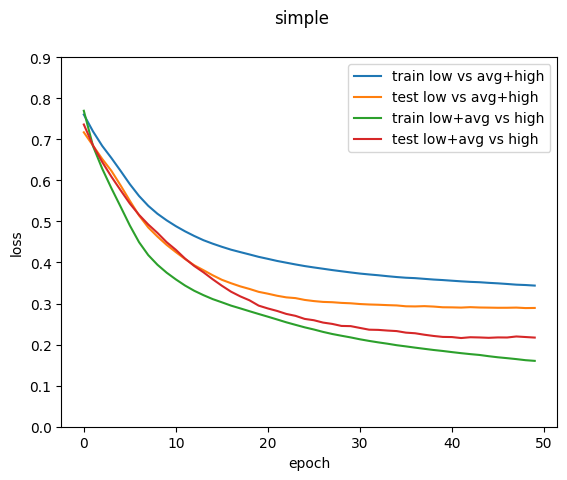

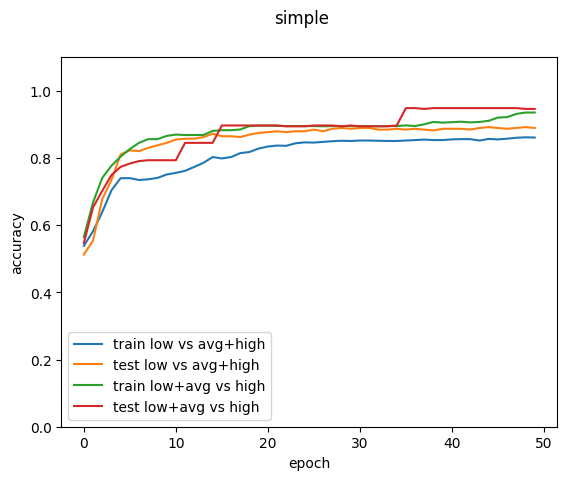

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Package Volume (cm3)', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Average fraction of mistakes: simple 0.16433566433566432
Average fraction of sure decisions: simple 0.6888111888111889
Average fraction of mistakes on sure decisions: simple 0.09137055837563451


<Figure size 640x480 with 0 Axes>

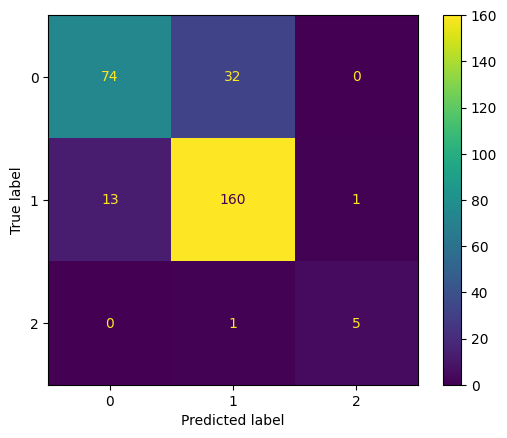

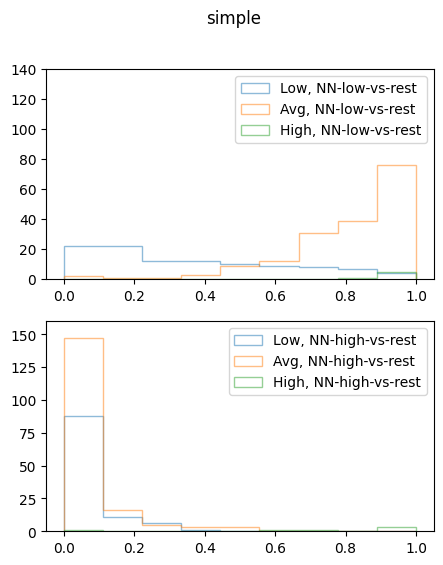

Will ignore feature Package ID
Will ignore feature Quality
Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(N

2022-11-30 08:23:44.675947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:23:44.689629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:23:45.161093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.6022 - low_vs_avghigh_loss: 0.8445 - lowavg_vs_high_loss: 0.7577 - low_vs_avghigh_accuracy: 0.4672 - lowavg_vs_high_accuracy: 0.5362

2022-11-30 08:23:46.219025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 2s 27ms/step - loss: 1.6022 - low_vs_avghigh_loss: 0.8445 - lowavg_vs_high_loss: 0.7577 - low_vs_avghigh_accuracy: 0.4672 - lowavg_vs_high_accuracy: 0.5362 - val_loss: 1.3719 - val_low_vs_avghigh_loss: 0.7298 - val_lowavg_vs_high_loss: 0.6421 - val_low_vs_avghigh_accuracy: 0.5320 - val_lowavg_vs_high_accuracy: 0.6527
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4281 - low_vs_avghigh_loss: 0.7809 - lowavg_vs_high_loss: 0.6472 - low_vs_avghigh_accuracy: 0.5068 - lowavg_vs_high_accuracy: 0.6387 - val_loss: 1.2525 - val_low_vs_avghigh_loss: 0.6762 - val_lowavg_vs_high_loss: 0.5763 - val_low_vs_avghigh_accuracy: 0.6133 - val_lowavg_vs_high_accuracy: 0.6872
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 1.3081 - low_vs_avghigh_loss: 0.7246 - lowavg_vs_high_loss: 0.5835 - low_vs_avghigh_accuracy: 0.5758 - lowavg_vs_high_accuracy: 0.6933 - val_loss: 1.1669 - val_low_vs_avghigh_loss: 0.6323 - val_lo

46/46 [==============================] - 1s 12ms/step - loss: 0.6028 - low_vs_avghigh_loss: 0.3775 - lowavg_vs_high_loss: 0.2253 - low_vs_avghigh_accuracy: 0.8552 - lowavg_vs_high_accuracy: 0.8900 - val_loss: 0.6054 - val_low_vs_avghigh_loss: 0.3108 - val_lowavg_vs_high_loss: 0.2947 - val_low_vs_avghigh_accuracy: 0.8670 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5925 - low_vs_avghigh_loss: 0.3743 - lowavg_vs_high_loss: 0.2182 - low_vs_avghigh_accuracy: 0.8566 - lowavg_vs_high_accuracy: 0.8948 - val_loss: 0.6029 - val_low_vs_avghigh_loss: 0.3076 - val_lowavg_vs_high_loss: 0.2952 - val_low_vs_avghigh_accuracy: 0.8793 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 0.5835 - low_vs_avghigh_loss: 0.3716 - lowavg_vs_high_loss: 0.2119 - low_vs_avghigh_accuracy: 0.8579 - lowavg_vs_high_accuracy: 0.9023 - val_loss: 0.5987 - val_low_vs_avghigh_loss: 0.3044 - val_

46/46 [==============================] - 1s 12ms/step - loss: 0.4650 - low_vs_avghigh_loss: 0.3392 - lowavg_vs_high_loss: 0.1258 - low_vs_avghigh_accuracy: 0.8682 - lowavg_vs_high_accuracy: 0.9467 - val_loss: 0.7077 - val_low_vs_avghigh_loss: 0.2958 - val_lowavg_vs_high_loss: 0.4119 - val_low_vs_avghigh_accuracy: 0.8768 - val_lowavg_vs_high_accuracy: 0.8842


INFO:tensorflow:Assets written to: base/model/assets


INFO:tensorflow:Assets written to: base/model/assets


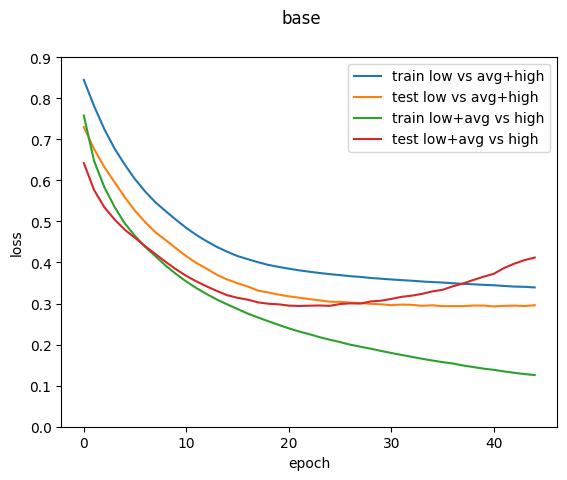

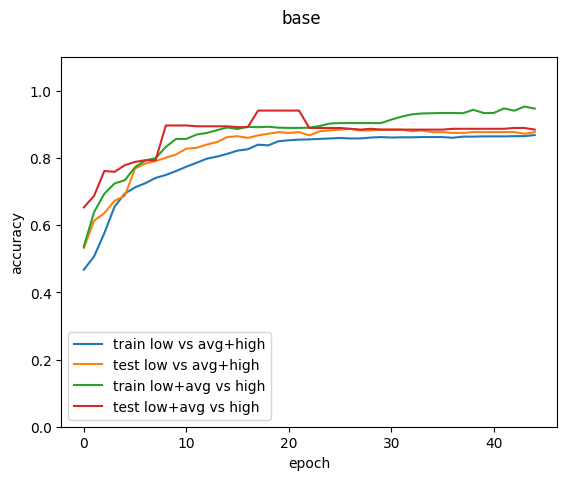

Average fraction of mistakes: base 0.1853146853146853
Average fraction of sure decisions: base 0.583916083916084
Average fraction of mistakes on sure decisions: base 0.08982035928143713


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

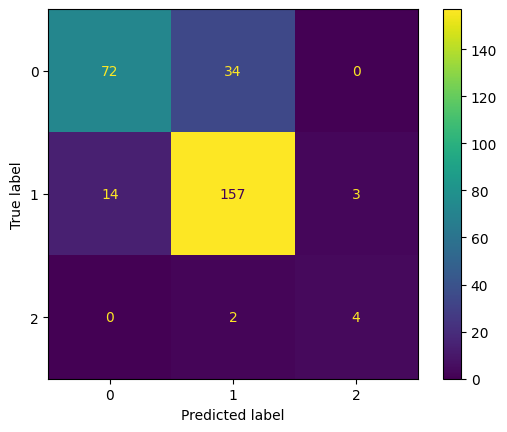

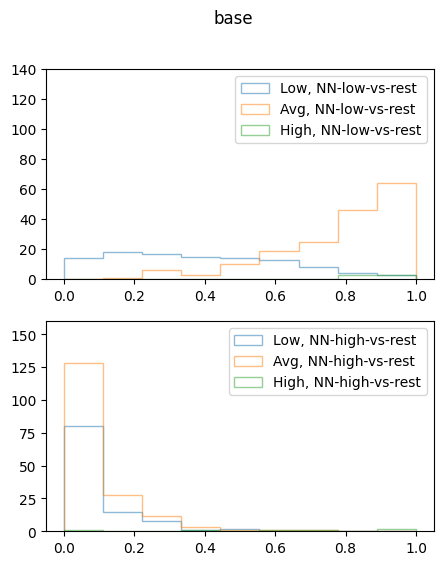

Will ignore feature Package ID
Will ignore feature Quality
Model: "dropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  

2022-11-30 08:24:12.354009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:24:12.367594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


                                                                  'PackageWeightg[0][0]',         
                                                                  'ProductionMill[0][0]',         
                                                                  'ProductionRecipe[0][0]',       
                                                                  'Proteinsg100g[0][0]',          
                                                                  'StarchContent[0][0]']          
                                                                                                  
 dense_4 (Dense)                (None, 12)           252         ['model_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 12)           0           ['dense_4[0][0]']                
                                                                                                  
 low_vs_av

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:24:12.857288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.7830 - low_vs_avghigh_loss: 0.9101 - lowavg_vs_high_loss: 0.8730 - low_vs_avghigh_accuracy: 0.4809 - lowavg_vs_high_accuracy: 0.4904

2022-11-30 08:24:14.076274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 2s 30ms/step - loss: 1.7830 - low_vs_avghigh_loss: 0.9101 - lowavg_vs_high_loss: 0.8730 - low_vs_avghigh_accuracy: 0.4809 - lowavg_vs_high_accuracy: 0.4904 - val_loss: 1.4011 - val_low_vs_avghigh_loss: 0.7296 - val_lowavg_vs_high_loss: 0.6715 - val_low_vs_avghigh_accuracy: 0.5443 - val_lowavg_vs_high_accuracy: 0.6232
Epoch 2/50
46/46 [==============================] - 1s 13ms/step - loss: 1.6019 - low_vs_avghigh_loss: 0.8479 - lowavg_vs_high_loss: 0.7540 - low_vs_avghigh_accuracy: 0.5171 - lowavg_vs_high_accuracy: 0.5540 - val_loss: 1.2925 - val_low_vs_avghigh_loss: 0.6819 - val_lowavg_vs_high_loss: 0.6106 - val_low_vs_avghigh_accuracy: 0.6182 - val_lowavg_vs_high_accuracy: 0.6404
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 1.4869 - low_vs_avghigh_loss: 0.7897 - lowavg_vs_high_loss: 0.6973 - low_vs_avghigh_accuracy: 0.5396 - lowavg_vs_high_accuracy: 0.6113 - val_loss: 1.2219 - val_low_vs_avghigh_loss: 0.6449 - val_lo

46/46 [==============================] - 1s 12ms/step - loss: 0.8976 - low_vs_avghigh_loss: 0.5176 - lowavg_vs_high_loss: 0.3801 - low_vs_avghigh_accuracy: 0.7227 - lowavg_vs_high_accuracy: 0.8115 - val_loss: 0.7688 - val_low_vs_avghigh_loss: 0.3954 - val_lowavg_vs_high_loss: 0.3734 - val_low_vs_avghigh_accuracy: 0.8251 - val_lowavg_vs_high_accuracy: 0.8448
Epoch 24/50
46/46 [==============================] - 1s 12ms/step - loss: 0.8832 - low_vs_avghigh_loss: 0.5117 - lowavg_vs_high_loss: 0.3715 - low_vs_avghigh_accuracy: 0.7500 - lowavg_vs_high_accuracy: 0.8224 - val_loss: 0.7605 - val_low_vs_avghigh_loss: 0.3902 - val_lowavg_vs_high_loss: 0.3703 - val_low_vs_avghigh_accuracy: 0.8227 - val_lowavg_vs_high_accuracy: 0.8448
Epoch 25/50
46/46 [==============================] - 1s 12ms/step - loss: 0.8902 - low_vs_avghigh_loss: 0.5158 - lowavg_vs_high_loss: 0.3744 - low_vs_avghigh_accuracy: 0.7480 - lowavg_vs_high_accuracy: 0.8204 - val_loss: 0.7498 - val_low_vs_avghigh_loss: 0.3852 - val_

46/46 [==============================] - 1s 12ms/step - loss: 0.7500 - low_vs_avghigh_loss: 0.4657 - lowavg_vs_high_loss: 0.2842 - low_vs_avghigh_accuracy: 0.7855 - lowavg_vs_high_accuracy: 0.8538 - val_loss: 0.6649 - val_low_vs_avghigh_loss: 0.3360 - val_lowavg_vs_high_loss: 0.3288 - val_low_vs_avghigh_accuracy: 0.8571 - val_lowavg_vs_high_accuracy: 0.8966
Epoch 46/50
46/46 [==============================] - 1s 12ms/step - loss: 0.7679 - low_vs_avghigh_loss: 0.4796 - lowavg_vs_high_loss: 0.2884 - low_vs_avghigh_accuracy: 0.7780 - lowavg_vs_high_accuracy: 0.8579 - val_loss: 0.6652 - val_low_vs_avghigh_loss: 0.3354 - val_lowavg_vs_high_loss: 0.3298 - val_low_vs_avghigh_accuracy: 0.8621 - val_lowavg_vs_high_accuracy: 0.8941
Epoch 47/50
46/46 [==============================] - 1s 12ms/step - loss: 0.7566 - low_vs_avghigh_loss: 0.4690 - lowavg_vs_high_loss: 0.2876 - low_vs_avghigh_accuracy: 0.7951 - lowavg_vs_high_accuracy: 0.8586 - val_loss: 0.6634 - val_low_vs_avghigh_loss: 0.3352 - val_

INFO:tensorflow:Assets written to: dropout/model/assets


INFO:tensorflow:Assets written to: dropout/model/assets


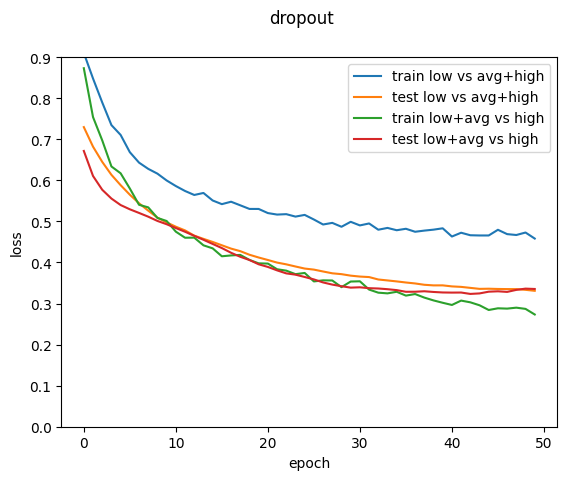

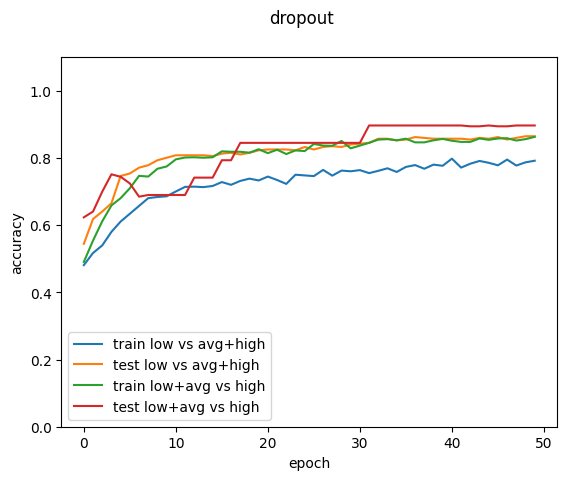

Average fraction of mistakes: dropout 0.1993006993006993
Average fraction of sure decisions: dropout 0.5524475524475524
Average fraction of mistakes on sure decisions: dropout 0.0759493670886076


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

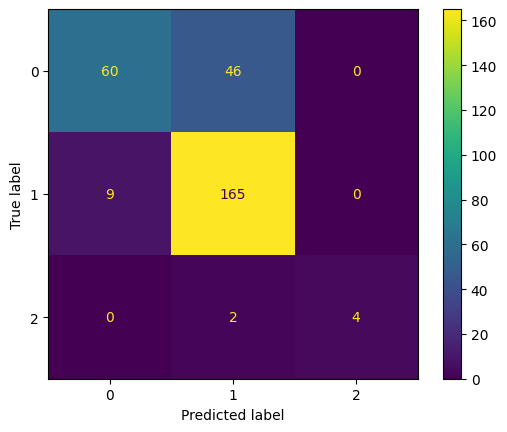

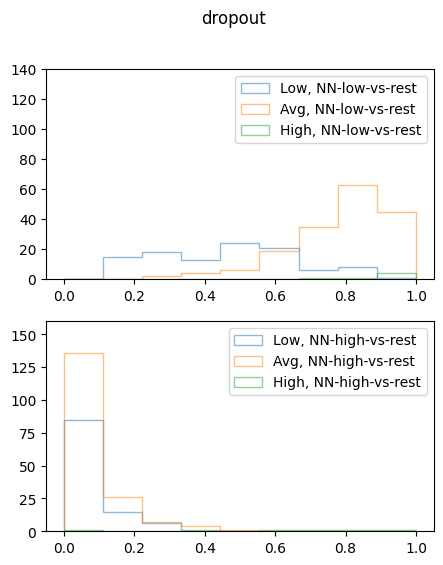

Will ignore feature Package ID
Will ignore feature Quality
Model: "long"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(N

2022-11-30 08:24:44.395865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:24:44.409456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:24:44.894475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.6085 - low_vs_avghigh_loss: 0.8451 - lowavg_vs_high_loss: 0.7634 - low_vs_avghigh_accuracy: 0.4597 - lowavg_vs_high_accuracy: 0.5307

2022-11-30 08:24:45.990837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 2s 29ms/step - loss: 1.6085 - low_vs_avghigh_loss: 0.8451 - lowavg_vs_high_loss: 0.7634 - low_vs_avghigh_accuracy: 0.4597 - lowavg_vs_high_accuracy: 0.5307 - val_loss: 1.3792 - val_low_vs_avghigh_loss: 0.7295 - val_lowavg_vs_high_loss: 0.6497 - val_low_vs_avghigh_accuracy: 0.5320 - val_lowavg_vs_high_accuracy: 0.6355
Epoch 2/100
46/46 [==============================] - 1s 14ms/step - loss: 1.4362 - low_vs_avghigh_loss: 0.7817 - lowavg_vs_high_loss: 0.6545 - low_vs_avghigh_accuracy: 0.5130 - lowavg_vs_high_accuracy: 0.6277 - val_loss: 1.2611 - val_low_vs_avghigh_loss: 0.6810 - val_lowavg_vs_high_loss: 0.5802 - val_low_vs_avghigh_accuracy: 0.5690 - val_lowavg_vs_high_accuracy: 0.6798
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: 1.3151 - low_vs_avghigh_loss: 0.7293 - lowavg_vs_high_loss: 0.5858 - low_vs_avghigh_accuracy: 0.5765 - lowavg_vs_high_accuracy: 0.6872 - val_loss: 1.1793 - val_low_vs_avghigh_loss: 0.6395 - val_

46/46 [==============================] - 1s 12ms/step - loss: 0.6072 - low_vs_avghigh_loss: 0.3805 - lowavg_vs_high_loss: 0.2267 - low_vs_avghigh_accuracy: 0.8545 - lowavg_vs_high_accuracy: 0.8907 - val_loss: 0.6115 - val_low_vs_avghigh_loss: 0.3132 - val_lowavg_vs_high_loss: 0.2982 - val_low_vs_avghigh_accuracy: 0.8842 - val_lowavg_vs_high_accuracy: 0.8916
Epoch 24/100
46/46 [==============================] - 1s 12ms/step - loss: 0.5971 - low_vs_avghigh_loss: 0.3775 - lowavg_vs_high_loss: 0.2196 - low_vs_avghigh_accuracy: 0.8586 - lowavg_vs_high_accuracy: 0.8900 - val_loss: 0.6108 - val_low_vs_avghigh_loss: 0.3122 - val_lowavg_vs_high_loss: 0.2985 - val_low_vs_avghigh_accuracy: 0.8818 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 25/100
46/46 [==============================] - 1s 12ms/step - loss: 0.5873 - low_vs_avghigh_loss: 0.3744 - lowavg_vs_high_loss: 0.2129 - low_vs_avghigh_accuracy: 0.8620 - lowavg_vs_high_accuracy: 0.8921 - val_loss: 0.6088 - val_low_vs_avghigh_loss: 0.3087 - va

Epoch 45/100
46/46 [==============================] - 1s 12ms/step - loss: 0.4665 - low_vs_avghigh_loss: 0.3412 - lowavg_vs_high_loss: 0.1253 - low_vs_avghigh_accuracy: 0.8648 - lowavg_vs_high_accuracy: 0.9488 - val_loss: 0.7243 - val_low_vs_avghigh_loss: 0.3031 - val_lowavg_vs_high_loss: 0.4211 - val_low_vs_avghigh_accuracy: 0.8695 - val_lowavg_vs_high_accuracy: 0.8867
Epoch 46/100
46/46 [==============================] - 1s 12ms/step - loss: 0.4620 - low_vs_avghigh_loss: 0.3398 - lowavg_vs_high_loss: 0.1223 - low_vs_avghigh_accuracy: 0.8627 - lowavg_vs_high_accuracy: 0.9617 - val_loss: 0.7352 - val_low_vs_avghigh_loss: 0.3050 - val_lowavg_vs_high_loss: 0.4302 - val_low_vs_avghigh_accuracy: 0.8695 - val_lowavg_vs_high_accuracy: 0.8867


INFO:tensorflow:Assets written to: long/model/assets


INFO:tensorflow:Assets written to: long/model/assets


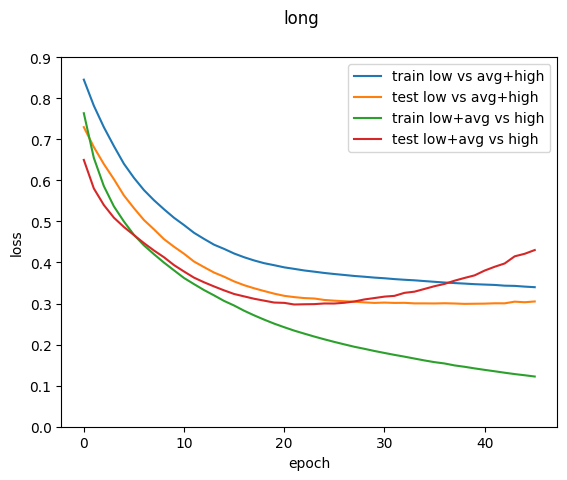

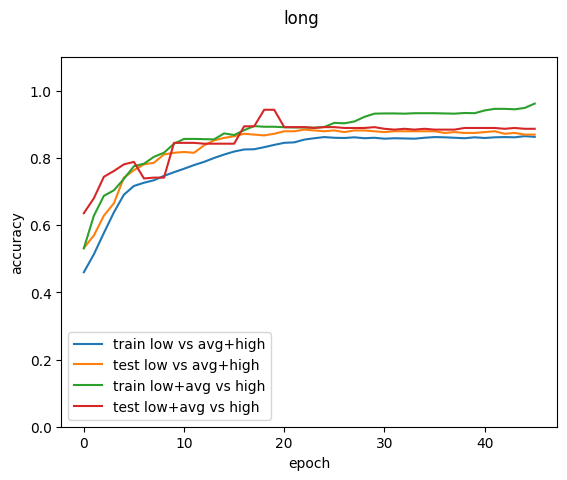

Average fraction of mistakes: long 0.18181818181818182
Average fraction of sure decisions: long 0.5804195804195804
Average fraction of mistakes on sure decisions: long 0.0783132530120482


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

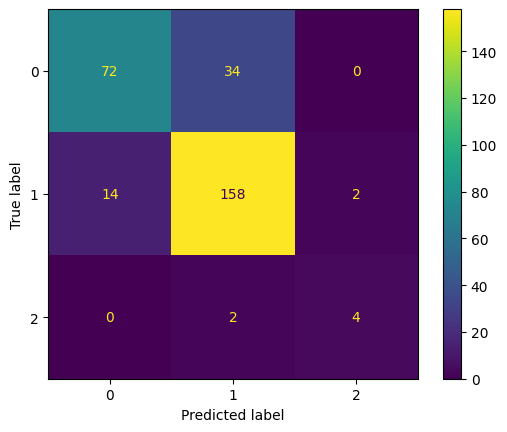

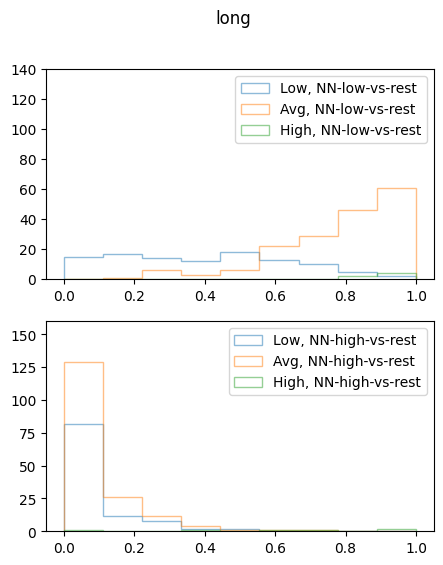

2022-11-30 08:25:13.671722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:25:13.685484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "deep"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(N

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:25:14.243776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.3978 - low_vs_avghigh_loss: 0.7104 - lowavg_vs_high_loss: 0.6875 - low_vs_avghigh_accuracy: 0.5061 - lowavg_vs_high_accuracy: 0.6113

2022-11-30 08:25:15.864903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 42ms/step - loss: 1.3978 - low_vs_avghigh_loss: 0.7104 - lowavg_vs_high_loss: 0.6875 - low_vs_avghigh_accuracy: 0.5061 - lowavg_vs_high_accuracy: 0.6113 - val_loss: 1.3642 - val_low_vs_avghigh_loss: 0.7047 - val_lowavg_vs_high_loss: 0.6595 - val_low_vs_avghigh_accuracy: 0.4310 - val_lowavg_vs_high_accuracy: 0.7463
Epoch 2/200
46/46 [==============================] - 1s 16ms/step - loss: 1.3330 - low_vs_avghigh_loss: 0.7138 - lowavg_vs_high_loss: 0.6191 - low_vs_avghigh_accuracy: 0.4925 - lowavg_vs_high_accuracy: 0.7179 - val_loss: 1.3190 - val_low_vs_avghigh_loss: 0.6830 - val_lowavg_vs_high_loss: 0.6360 - val_low_vs_avghigh_accuracy: 0.5567 - val_lowavg_vs_high_accuracy: 0.7266
Epoch 3/200
46/46 [==============================] - 1s 14ms/step - loss: 1.2556 - low_vs_avghigh_loss: 0.6772 - lowavg_vs_high_loss: 0.5784 - low_vs_avghigh_accuracy: 0.5779 - lowavg_vs_high_accuracy: 0.7596 - val_loss: 1.2794 - val_low_vs_avghigh_loss: 0.6607 - val_

46/46 [==============================] - 1s 13ms/step - loss: 0.7744 - low_vs_avghigh_loss: 0.4554 - lowavg_vs_high_loss: 0.3190 - low_vs_avghigh_accuracy: 0.7999 - lowavg_vs_high_accuracy: 0.8463 - val_loss: 0.8940 - val_low_vs_avghigh_loss: 0.3835 - val_lowavg_vs_high_loss: 0.5105 - val_low_vs_avghigh_accuracy: 0.8399 - val_lowavg_vs_high_accuracy: 0.8941
Epoch 24/200
46/46 [==============================] - 1s 14ms/step - loss: 0.7653 - low_vs_avghigh_loss: 0.4600 - lowavg_vs_high_loss: 0.3053 - low_vs_avghigh_accuracy: 0.7958 - lowavg_vs_high_accuracy: 0.8511 - val_loss: 0.8873 - val_low_vs_avghigh_loss: 0.3806 - val_lowavg_vs_high_loss: 0.5067 - val_low_vs_avghigh_accuracy: 0.8374 - val_lowavg_vs_high_accuracy: 0.8941
Epoch 25/200
46/46 [==============================] - 1s 13ms/step - loss: 0.7203 - low_vs_avghigh_loss: 0.4323 - lowavg_vs_high_loss: 0.2880 - low_vs_avghigh_accuracy: 0.8149 - lowavg_vs_high_accuracy: 0.8593 - val_loss: 0.8921 - val_low_vs_avghigh_loss: 0.3802 - va

INFO:tensorflow:Assets written to: deep/model/assets


INFO:tensorflow:Assets written to: deep/model/assets


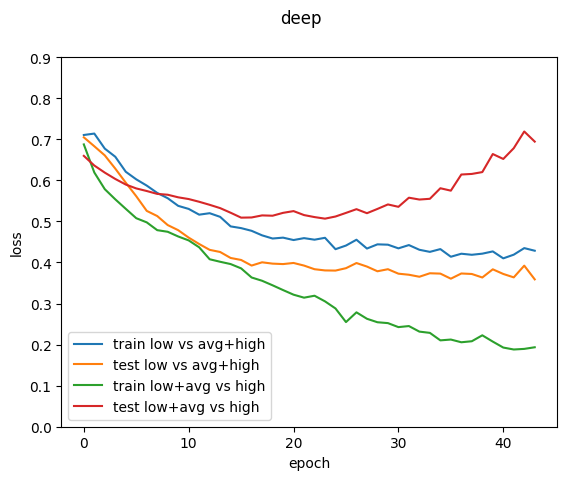

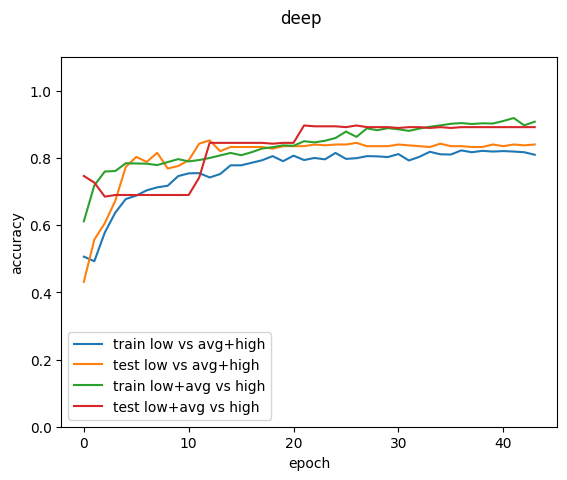

Average fraction of mistakes: deep 0.16433566433566432
Average fraction of sure decisions: deep 0.5
Average fraction of mistakes on sure decisions: deep 0.07692307692307693


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

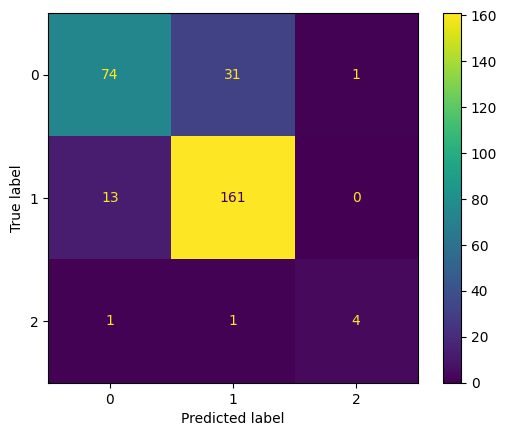

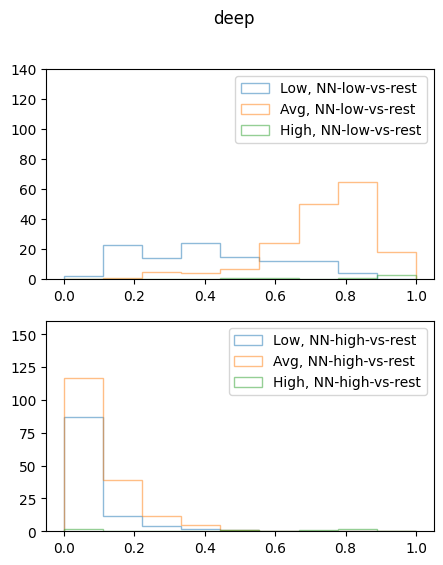

2022-11-30 08:25:44.729922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:25:44.743564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Production Recipe
Will ignore feature Production Mill
Will ignore feature Quality
Model: "deep_no_cat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                      

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:25:45.305073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.5688 - low_vs_avghigh_loss: 0.7326 - lowavg_vs_high_loss: 0.8363 - low_vs_avghigh_accuracy: 0.5430 - lowavg_vs_high_accuracy: 0.5280

2022-11-30 08:25:47.036750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 41ms/step - loss: 1.5688 - low_vs_avghigh_loss: 0.7326 - lowavg_vs_high_loss: 0.8363 - low_vs_avghigh_accuracy: 0.5430 - lowavg_vs_high_accuracy: 0.5280 - val_loss: 1.3611 - val_low_vs_avghigh_loss: 0.6876 - val_lowavg_vs_high_loss: 0.6735 - val_low_vs_avghigh_accuracy: 0.4557 - val_lowavg_vs_high_accuracy: 0.6133
Epoch 2/200
46/46 [==============================] - 1s 14ms/step - loss: 1.4026 - low_vs_avghigh_loss: 0.7176 - lowavg_vs_high_loss: 0.6850 - low_vs_avghigh_accuracy: 0.5355 - lowavg_vs_high_accuracy: 0.6475 - val_loss: 1.3410 - val_low_vs_avghigh_loss: 0.6915 - val_lowavg_vs_high_loss: 0.6495 - val_low_vs_avghigh_accuracy: 0.4507 - val_lowavg_vs_high_accuracy: 0.6897
Epoch 3/200
46/46 [==============================] - 1s 14ms/step - loss: 1.3211 - low_vs_avghigh_loss: 0.6893 - lowavg_vs_high_loss: 0.6319 - low_vs_avghigh_accuracy: 0.5615 - lowavg_vs_high_accuracy: 0.7234 - val_loss: 1.3117 - val_low_vs_avghigh_loss: 0.6699 - val_

46/46 [==============================] - 1s 12ms/step - loss: 1.0148 - low_vs_avghigh_loss: 0.5143 - lowavg_vs_high_loss: 0.5005 - low_vs_avghigh_accuracy: 0.7657 - lowavg_vs_high_accuracy: 0.7698 - val_loss: 1.0752 - val_low_vs_avghigh_loss: 0.4326 - val_lowavg_vs_high_loss: 0.6426 - val_low_vs_avghigh_accuracy: 0.8276 - val_lowavg_vs_high_accuracy: 0.6897
Epoch 24/200
46/46 [==============================] - 1s 15ms/step - loss: 1.0056 - low_vs_avghigh_loss: 0.4958 - lowavg_vs_high_loss: 0.5099 - low_vs_avghigh_accuracy: 0.7746 - lowavg_vs_high_accuracy: 0.7698 - val_loss: 1.0590 - val_low_vs_avghigh_loss: 0.4241 - val_lowavg_vs_high_loss: 0.6349 - val_low_vs_avghigh_accuracy: 0.8276 - val_lowavg_vs_high_accuracy: 0.6897
Epoch 25/200
46/46 [==============================] - 1s 14ms/step - loss: 1.0076 - low_vs_avghigh_loss: 0.5020 - lowavg_vs_high_loss: 0.5056 - low_vs_avghigh_accuracy: 0.7616 - lowavg_vs_high_accuracy: 0.7698 - val_loss: 1.0659 - val_low_vs_avghigh_loss: 0.4257 - va

Epoch 45/200
46/46 [==============================] - 1s 12ms/step - loss: 0.9025 - low_vs_avghigh_loss: 0.4525 - lowavg_vs_high_loss: 0.4500 - low_vs_avghigh_accuracy: 0.7978 - lowavg_vs_high_accuracy: 0.7705 - val_loss: 1.1020 - val_low_vs_avghigh_loss: 0.4136 - val_lowavg_vs_high_loss: 0.6884 - val_low_vs_avghigh_accuracy: 0.7833 - val_lowavg_vs_high_accuracy: 0.6897
Epoch 46/200
46/46 [==============================] - 1s 12ms/step - loss: 0.8693 - low_vs_avghigh_loss: 0.4379 - lowavg_vs_high_loss: 0.4315 - low_vs_avghigh_accuracy: 0.8026 - lowavg_vs_high_accuracy: 0.7698 - val_loss: 1.1090 - val_low_vs_avghigh_loss: 0.4125 - val_lowavg_vs_high_loss: 0.6965 - val_low_vs_avghigh_accuracy: 0.7808 - val_lowavg_vs_high_accuracy: 0.6897
Epoch 47/200
46/46 [==============================] - 1s 12ms/step - loss: 0.8720 - low_vs_avghigh_loss: 0.4342 - lowavg_vs_high_loss: 0.4378 - low_vs_avghigh_accuracy: 0.8094 - lowavg_vs_high_accuracy: 0.7698 - val_loss: 1.1212 - val_low_vs_avghigh_loss

INFO:tensorflow:Assets written to: deep_no_cat/model/assets


INFO:tensorflow:Assets written to: deep_no_cat/model/assets


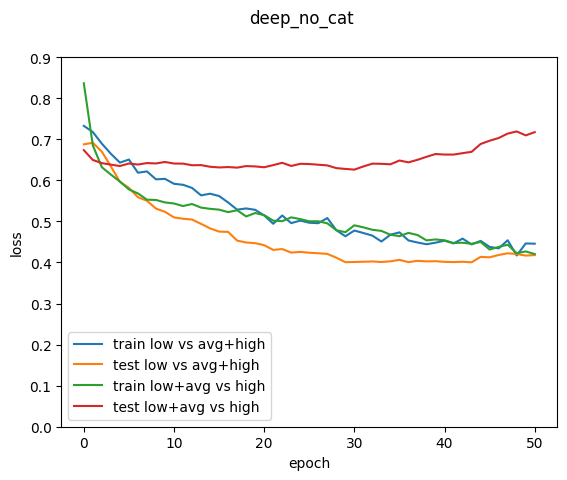

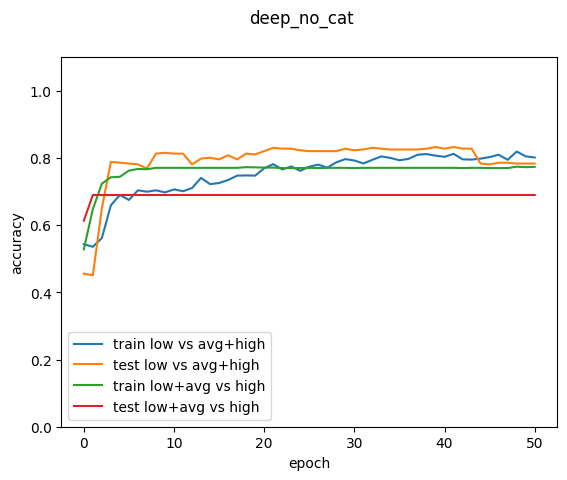

Average fraction of mistakes: deep_no_cat 0.1993006993006993
Average fraction of sure decisions: deep_no_cat 0.6468531468531469
Average fraction of mistakes on sure decisions: deep_no_cat 0.0972972972972973


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

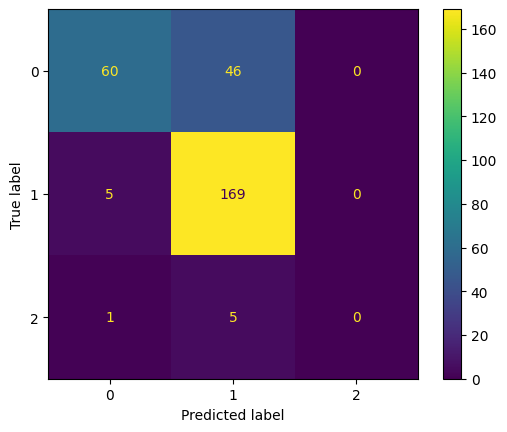

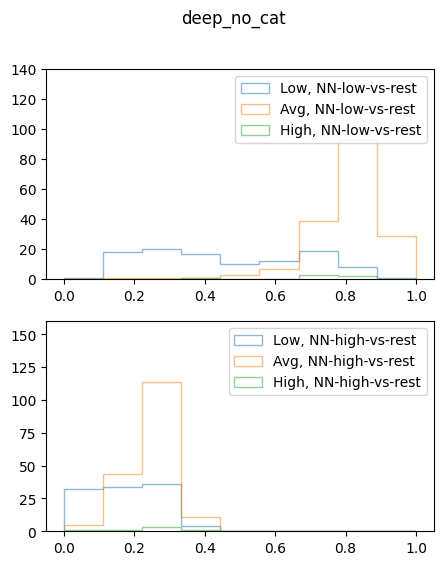

2022-11-30 08:26:17.331479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:26:17.345412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "deep_sum"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay 

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:26:17.907325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.4312 - low_vs_avghigh_loss: 0.7362 - lowavg_vs_high_loss: 0.6950 - low_vs_avghigh_accuracy: 0.4604 - lowavg_vs_high_accuracy: 0.5867

2022-11-30 08:26:19.605471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 42ms/step - loss: 1.4312 - low_vs_avghigh_loss: 0.7362 - lowavg_vs_high_loss: 0.6950 - low_vs_avghigh_accuracy: 0.4604 - lowavg_vs_high_accuracy: 0.5867 - val_loss: 1.3678 - val_low_vs_avghigh_loss: 0.7002 - val_lowavg_vs_high_loss: 0.6675 - val_low_vs_avghigh_accuracy: 0.4557 - val_lowavg_vs_high_accuracy: 0.7291
Epoch 2/200
46/46 [==============================] - 1s 15ms/step - loss: 1.3258 - low_vs_avghigh_loss: 0.7016 - lowavg_vs_high_loss: 0.6242 - low_vs_avghigh_accuracy: 0.5239 - lowavg_vs_high_accuracy: 0.7097 - val_loss: 1.3368 - val_low_vs_avghigh_loss: 0.6868 - val_lowavg_vs_high_loss: 0.6500 - val_low_vs_avghigh_accuracy: 0.5788 - val_lowavg_vs_high_accuracy: 0.7241
Epoch 3/200
46/46 [==============================] - 1s 15ms/step - loss: 1.2707 - low_vs_avghigh_loss: 0.6815 - lowavg_vs_high_loss: 0.5891 - low_vs_avghigh_accuracy: 0.5874 - lowavg_vs_high_accuracy: 0.7384 - val_loss: 1.3012 - val_low_vs_avghigh_loss: 0.6709 - val_

46/46 [==============================] - 1s 13ms/step - loss: 0.7871 - low_vs_avghigh_loss: 0.4748 - lowavg_vs_high_loss: 0.3123 - low_vs_avghigh_accuracy: 0.7814 - lowavg_vs_high_accuracy: 0.8531 - val_loss: 0.8522 - val_low_vs_avghigh_loss: 0.3826 - val_lowavg_vs_high_loss: 0.4696 - val_low_vs_avghigh_accuracy: 0.8350 - val_lowavg_vs_high_accuracy: 0.8966
Epoch 24/200
46/46 [==============================] - 1s 13ms/step - loss: 0.7725 - low_vs_avghigh_loss: 0.4625 - lowavg_vs_high_loss: 0.3100 - low_vs_avghigh_accuracy: 0.7971 - lowavg_vs_high_accuracy: 0.8607 - val_loss: 0.8587 - val_low_vs_avghigh_loss: 0.3832 - val_lowavg_vs_high_loss: 0.4755 - val_low_vs_avghigh_accuracy: 0.8325 - val_lowavg_vs_high_accuracy: 0.8966
Epoch 25/200
46/46 [==============================] - 1s 14ms/step - loss: 0.7448 - low_vs_avghigh_loss: 0.4490 - lowavg_vs_high_loss: 0.2958 - low_vs_avghigh_accuracy: 0.7883 - lowavg_vs_high_accuracy: 0.8538 - val_loss: 0.8510 - val_low_vs_avghigh_loss: 0.3704 - va

Epoch 45/200
46/46 [==============================] - 1s 14ms/step - loss: 0.6028 - low_vs_avghigh_loss: 0.4124 - lowavg_vs_high_loss: 0.1904 - low_vs_avghigh_accuracy: 0.8190 - lowavg_vs_high_accuracy: 0.9180 - val_loss: 1.1092 - val_low_vs_avghigh_loss: 0.3691 - val_lowavg_vs_high_loss: 0.7401 - val_low_vs_avghigh_accuracy: 0.8350 - val_lowavg_vs_high_accuracy: 0.8966


INFO:tensorflow:Assets written to: deep_sum/model/assets


INFO:tensorflow:Assets written to: deep_sum/model/assets


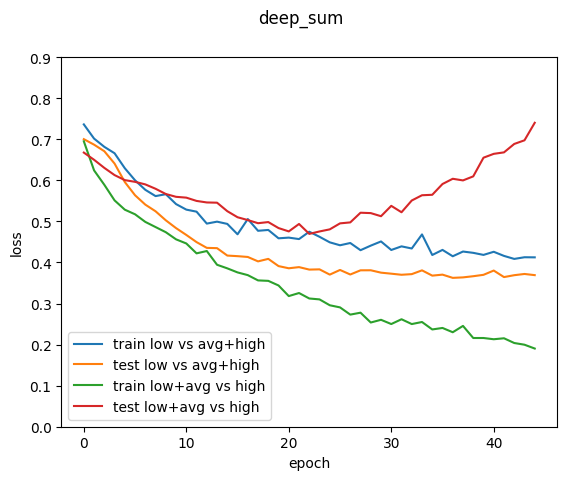

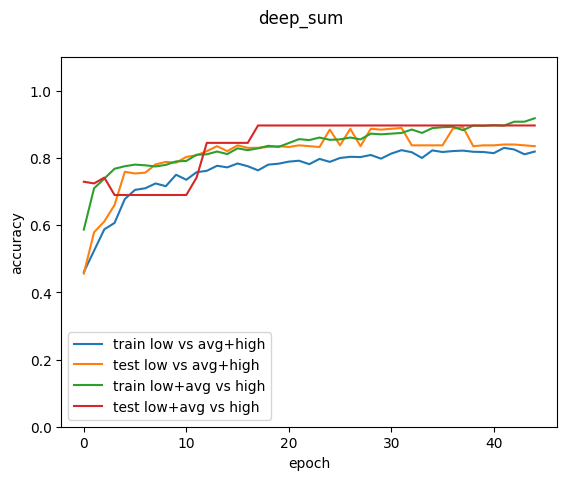

Average fraction of mistakes: deep_sum 0.17132867132867133
Average fraction of sure decisions: deep_sum 0.5034965034965035
Average fraction of mistakes on sure decisions: deep_sum 0.08333333333333333


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

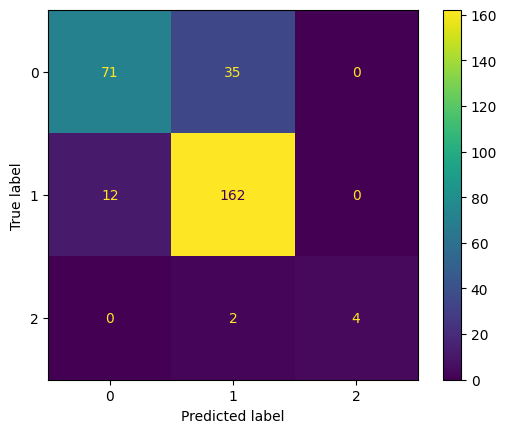

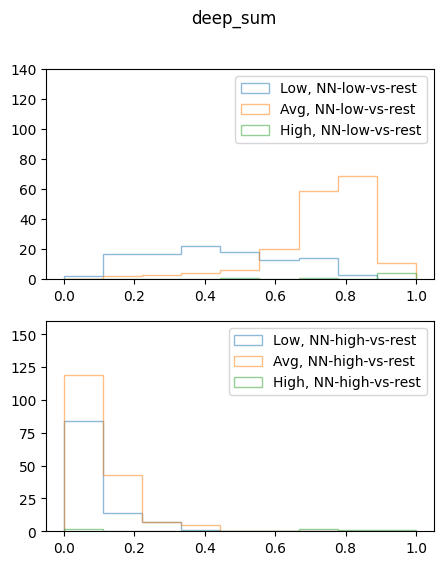

2022-11-30 08:26:50.173370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:26:50.188257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "deep_l1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:26:50.770332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 2.4260 - low_vs_avghigh_loss: 0.7000 - lowavg_vs_high_loss: 0.6683 - low_vs_avghigh_accuracy: 0.4754 - lowavg_vs_high_accuracy: 0.6407

2022-11-30 08:26:52.589145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 48ms/step - loss: 2.4260 - low_vs_avghigh_loss: 0.7000 - lowavg_vs_high_loss: 0.6683 - low_vs_avghigh_accuracy: 0.4754 - lowavg_vs_high_accuracy: 0.6407 - val_loss: 2.3227 - val_low_vs_avghigh_loss: 0.7017 - val_lowavg_vs_high_loss: 0.6475 - val_low_vs_avghigh_accuracy: 0.4803 - val_lowavg_vs_high_accuracy: 0.7562
Epoch 2/100
46/46 [==============================] - 1s 17ms/step - loss: 2.1622 - low_vs_avghigh_loss: 0.6827 - lowavg_vs_high_loss: 0.5799 - low_vs_avghigh_accuracy: 0.5102 - lowavg_vs_high_accuracy: 0.8190 - val_loss: 2.1346 - val_low_vs_avghigh_loss: 0.6937 - val_lowavg_vs_high_loss: 0.6144 - val_low_vs_avghigh_accuracy: 0.5345 - val_lowavg_vs_high_accuracy: 0.7389
Epoch 3/100
46/46 [==============================] - 1s 15ms/step - loss: 1.9300 - low_vs_avghigh_loss: 0.6529 - lowavg_vs_high_loss: 0.5110 - low_vs_avghigh_accuracy: 0.6072 - lowavg_vs_high_accuracy: 0.8108 - val_loss: 1.9338 - val_low_vs_avghigh_loss: 0.6311 - val_

46/46 [==============================] - 1s 13ms/step - loss: 0.6869 - low_vs_avghigh_loss: 0.3522 - lowavg_vs_high_loss: 0.1329 - low_vs_avghigh_accuracy: 0.8525 - lowavg_vs_high_accuracy: 0.9378 - val_loss: 0.9943 - val_low_vs_avghigh_loss: 0.3435 - val_lowavg_vs_high_loss: 0.4497 - val_low_vs_avghigh_accuracy: 0.8251 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 24/100
46/46 [==============================] - 1s 13ms/step - loss: 0.6782 - low_vs_avghigh_loss: 0.3507 - lowavg_vs_high_loss: 0.1261 - low_vs_avghigh_accuracy: 0.8545 - lowavg_vs_high_accuracy: 0.9501 - val_loss: 1.0092 - val_low_vs_avghigh_loss: 0.3470 - val_lowavg_vs_high_loss: 0.4620 - val_low_vs_avghigh_accuracy: 0.8251 - val_lowavg_vs_high_accuracy: 0.8867
Epoch 25/100
46/46 [==============================] - 1s 13ms/step - loss: 0.6679 - low_vs_avghigh_loss: 0.3486 - lowavg_vs_high_loss: 0.1193 - low_vs_avghigh_accuracy: 0.8538 - lowavg_vs_high_accuracy: 0.9652 - val_loss: 1.0171 - val_low_vs_avghigh_loss: 0.3479 - va

INFO:tensorflow:Assets written to: deep_l1/model/assets


INFO:tensorflow:Assets written to: deep_l1/model/assets


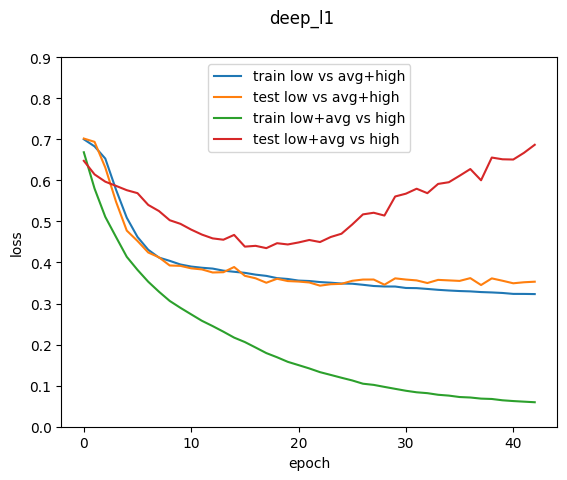

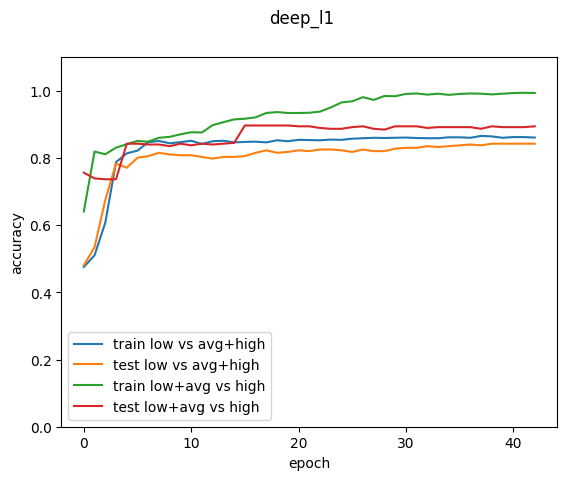

Average fraction of mistakes: deep_l1 0.19230769230769232
Average fraction of sure decisions: deep_l1 0.7027972027972028
Average fraction of mistakes on sure decisions: deep_l1 0.12935323383084577


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

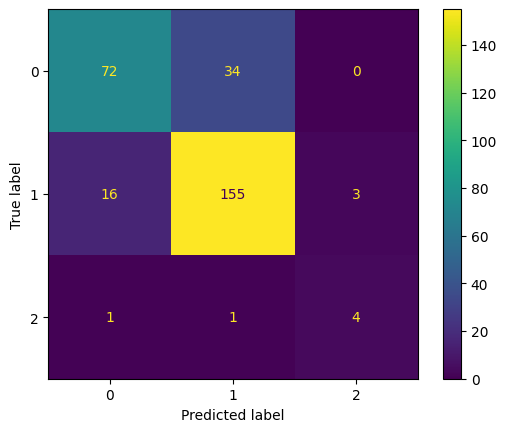

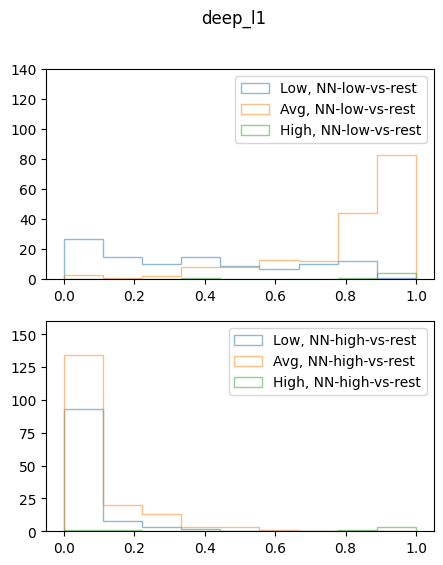

2022-11-30 08:27:21.743374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:27:21.757280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Package ID
Will ignore feature Quality
Model: "deep_l2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:27:22.354297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.6453 - low_vs_avghigh_loss: 0.7016 - lowavg_vs_high_loss: 0.6599 - low_vs_avghigh_accuracy: 0.4829 - lowavg_vs_high_accuracy: 0.6673

2022-11-30 08:27:24.034893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 41ms/step - loss: 1.6453 - low_vs_avghigh_loss: 0.7016 - lowavg_vs_high_loss: 0.6599 - low_vs_avghigh_accuracy: 0.4829 - lowavg_vs_high_accuracy: 0.6673 - val_loss: 1.6180 - val_low_vs_avghigh_loss: 0.7160 - val_lowavg_vs_high_loss: 0.6411 - val_low_vs_avghigh_accuracy: 0.4729 - val_lowavg_vs_high_accuracy: 0.7660
Epoch 2/100
46/46 [==============================] - 1s 17ms/step - loss: 1.4778 - low_vs_avghigh_loss: 0.6816 - lowavg_vs_high_loss: 0.5524 - low_vs_avghigh_accuracy: 0.5191 - lowavg_vs_high_accuracy: 0.8333 - val_loss: 1.5363 - val_low_vs_avghigh_loss: 0.6954 - val_lowavg_vs_high_loss: 0.6130 - val_low_vs_avghigh_accuracy: 0.5394 - val_lowavg_vs_high_accuracy: 0.7340
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: 1.3157 - low_vs_avghigh_loss: 0.6225 - lowavg_vs_high_loss: 0.4757 - low_vs_avghigh_accuracy: 0.6824 - lowavg_vs_high_accuracy: 0.8272 - val_loss: 1.4135 - val_low_vs_avghigh_loss: 0.6044 - val_

46/46 [==============================] - 1s 13ms/step - loss: 0.5327 - low_vs_avghigh_loss: 0.3126 - lowavg_vs_high_loss: 0.0784 - low_vs_avghigh_accuracy: 0.8723 - lowavg_vs_high_accuracy: 0.9898 - val_loss: 1.3104 - val_low_vs_avghigh_loss: 0.3657 - val_lowavg_vs_high_loss: 0.8038 - val_low_vs_avghigh_accuracy: 0.8350 - val_lowavg_vs_high_accuracy: 0.8867
Epoch 24/100
46/46 [==============================] - 1s 13ms/step - loss: 0.5258 - low_vs_avghigh_loss: 0.3097 - lowavg_vs_high_loss: 0.0766 - low_vs_avghigh_accuracy: 0.8730 - lowavg_vs_high_accuracy: 0.9898 - val_loss: 1.3153 - val_low_vs_avghigh_loss: 0.3640 - val_lowavg_vs_high_loss: 0.8124 - val_low_vs_avghigh_accuracy: 0.8276 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 25/100
46/46 [==============================] - 1s 13ms/step - loss: 0.5213 - low_vs_avghigh_loss: 0.3099 - lowavg_vs_high_loss: 0.0732 - low_vs_avghigh_accuracy: 0.8716 - lowavg_vs_high_accuracy: 0.9891 - val_loss: 1.3599 - val_low_vs_avghigh_loss: 0.3706 - va

INFO:tensorflow:Assets written to: deep_l2/model/assets


INFO:tensorflow:Assets written to: deep_l2/model/assets


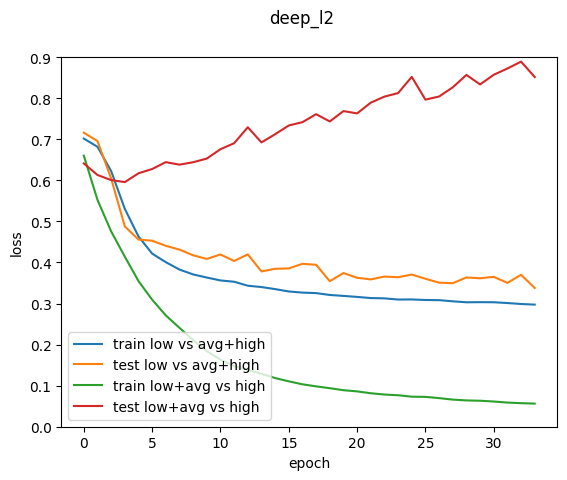

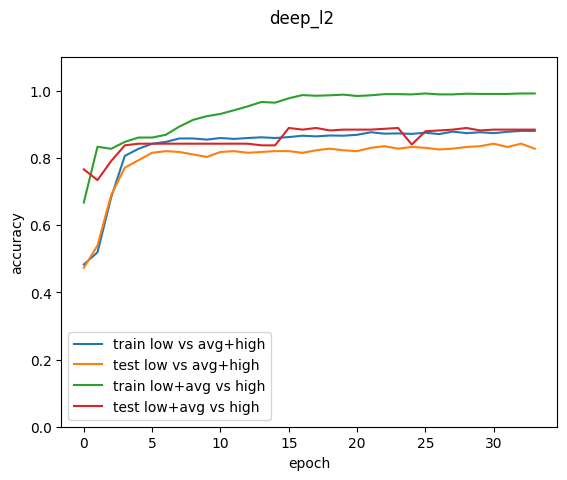

Average fraction of mistakes: deep_l2 0.20279720279720279
Average fraction of sure decisions: deep_l2 0.7097902097902098
Average fraction of mistakes on sure decisions: deep_l2 0.09852216748768473


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

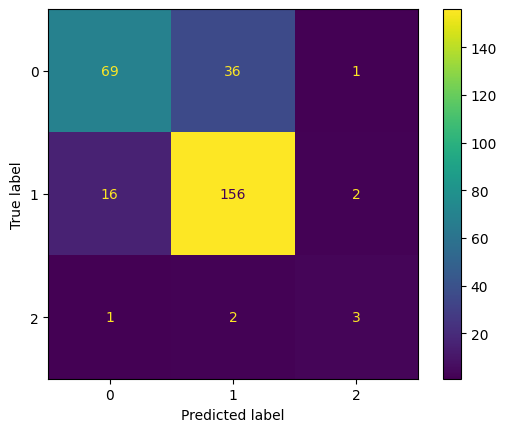

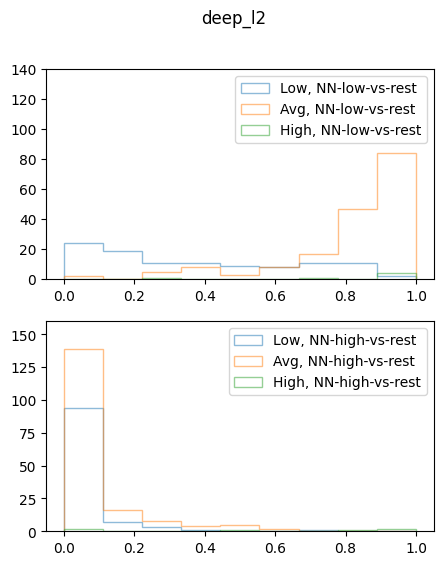

2022-11-30 08:27:46.674379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 08:27:46.689222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Will ignore feature Quality
Model: "deep_with_id"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Ashcontent (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Color (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 DampeningTimehours (InputLayer  [(None,)]           0           []                               
 )                                                                                                
                                                                                                  
 DoughElasticityIndex (InputLay  [(None,)]           0     

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-11-30 08:27:47.338405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 1.4493 - low_vs_avghigh_loss: 0.7312 - lowavg_vs_high_loss: 0.7181 - low_vs_avghigh_accuracy: 0.5082 - lowavg_vs_high_accuracy: 0.5553

2022-11-30 08:27:49.634926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 4s 60ms/step - loss: 1.4493 - low_vs_avghigh_loss: 0.7312 - lowavg_vs_high_loss: 0.7181 - low_vs_avghigh_accuracy: 0.5082 - lowavg_vs_high_accuracy: 0.5553 - val_loss: 1.3662 - val_low_vs_avghigh_loss: 0.7049 - val_lowavg_vs_high_loss: 0.6612 - val_low_vs_avghigh_accuracy: 0.5148 - val_lowavg_vs_high_accuracy: 0.6675
Epoch 2/200
46/46 [==============================] - 1s 19ms/step - loss: 1.3136 - low_vs_avghigh_loss: 0.6981 - lowavg_vs_high_loss: 0.6155 - low_vs_avghigh_accuracy: 0.5533 - lowavg_vs_high_accuracy: 0.7063 - val_loss: 1.3140 - val_low_vs_avghigh_loss: 0.6797 - val_lowavg_vs_high_loss: 0.6343 - val_low_vs_avghigh_accuracy: 0.7118 - val_lowavg_vs_high_accuracy: 0.6872
Epoch 3/200
46/46 [==============================] - 1s 17ms/step - loss: 1.2508 - low_vs_avghigh_loss: 0.6668 - lowavg_vs_high_loss: 0.5840 - low_vs_avghigh_accuracy: 0.6243 - lowavg_vs_high_accuracy: 0.7350 - val_loss: 1.2615 - val_low_vs_avghigh_loss: 0.6485 - val_

46/46 [==============================] - 1s 14ms/step - loss: 0.8023 - low_vs_avghigh_loss: 0.4951 - lowavg_vs_high_loss: 0.3071 - low_vs_avghigh_accuracy: 0.7534 - lowavg_vs_high_accuracy: 0.8600 - val_loss: 0.8970 - val_low_vs_avghigh_loss: 0.3907 - val_lowavg_vs_high_loss: 0.5063 - val_low_vs_avghigh_accuracy: 0.8350 - val_lowavg_vs_high_accuracy: 0.8892
Epoch 24/200
46/46 [==============================] - 1s 14ms/step - loss: 0.7656 - low_vs_avghigh_loss: 0.4741 - lowavg_vs_high_loss: 0.2915 - low_vs_avghigh_accuracy: 0.7753 - lowavg_vs_high_accuracy: 0.8702 - val_loss: 0.8847 - val_low_vs_avghigh_loss: 0.3864 - val_lowavg_vs_high_loss: 0.4984 - val_low_vs_avghigh_accuracy: 0.8399 - val_lowavg_vs_high_accuracy: 0.8867
Epoch 25/200
46/46 [==============================] - 1s 13ms/step - loss: 0.7498 - low_vs_avghigh_loss: 0.4595 - lowavg_vs_high_loss: 0.2903 - low_vs_avghigh_accuracy: 0.7855 - lowavg_vs_high_accuracy: 0.8689 - val_loss: 0.9152 - val_low_vs_avghigh_loss: 0.3905 - va

INFO:tensorflow:Assets written to: deep_with_id/model/assets


INFO:tensorflow:Assets written to: deep_with_id/model/assets


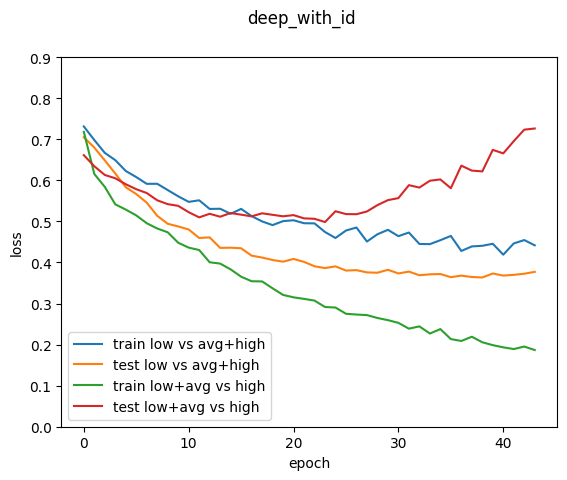

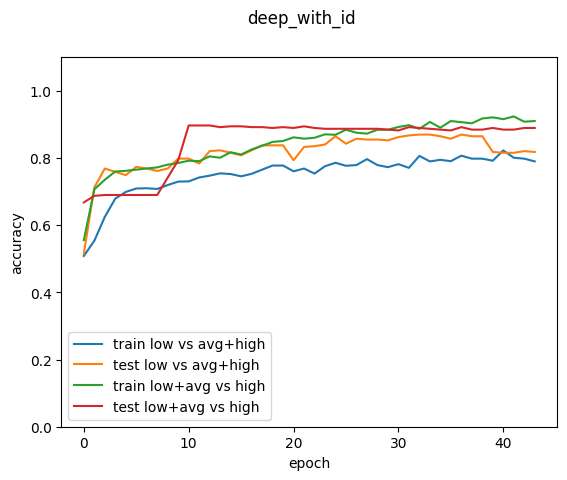

/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Average fraction of mistakes: deep_with_id 0.24475524475524477
Average fraction of sure decisions: deep_with_id 0.527972027972028
Average fraction of mistakes on sure decisions: deep_with_id 0.09271523178807947


<Figure size 640x480 with 0 Axes>

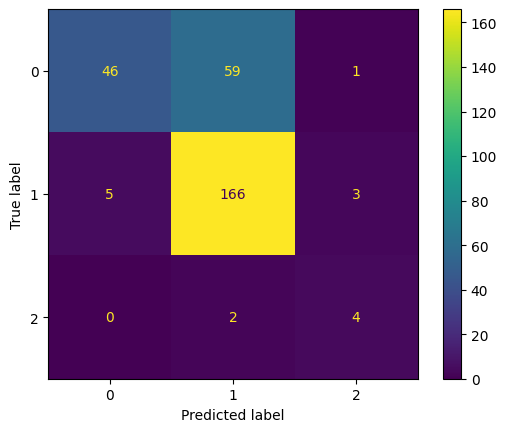

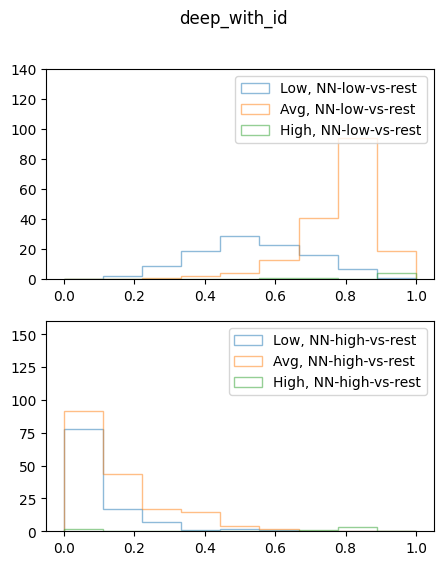

In [10]:
configs = {
    'simple':[
        {'simple':True},
        {},
    ],
    'base':[
        {},
        {},
    ],
    'dropout':[
        {'dropout':True},
        {},
    ],
    'long':[
        {},
        {'epochs':100},
    ],
    'deep':[
        {'dropout':True, 'deep':True},
        {'epochs':200},
    ],
    'deep_l2':[
        {'deep':True, 'kernel_regularizer':'l2'},
        {'epochs':100},
    ],
    'deep_l1':[
        {'deep':True, 'kernel_regularizer':'l1'},
        {'epochs':100},
    ],
}
configs['deep_sum'] = configs['deep']
configs['deep_no_cat'] = configs['deep']
configs['deep_with_id'] = configs['deep']

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df_resampled = resample_high(train_df,20) #resampled after splitting so that there is no mix
test_df_resampled  = resample_high(test_df,20)

train_y = get_labels(train_df_resampled)
test_y  = get_labels(test_df_resampled)

histories = {}

def run_all(name):
    model_kwargs, run_kwargs = configs[name]
    model = get_model(name, df, **model_kwargs)
    
    history = train_model(name, model, dict(train_df_resampled), train_y, 
                      validation_data=(dict(test_df_resampled), test_y),
                      **run_kwargs
                     )
    histories[name] = (history, model)
    
    validation_plots(name, history, model, test_df)

run_all('simple')
run_all('base')
run_all('dropout')
run_all('long')
run_all('deep')
run_all('deep_no_cat')
run_all('deep_sum')
run_all('deep_l1')
run_all('deep_l2')
run_all('deep_with_id')

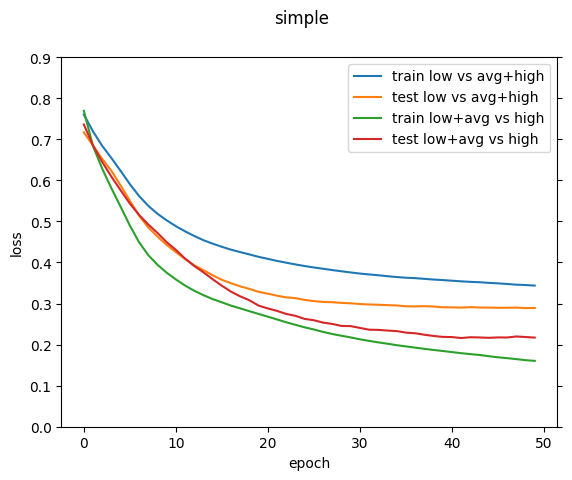

Max val accuracy 0.8916255831718445


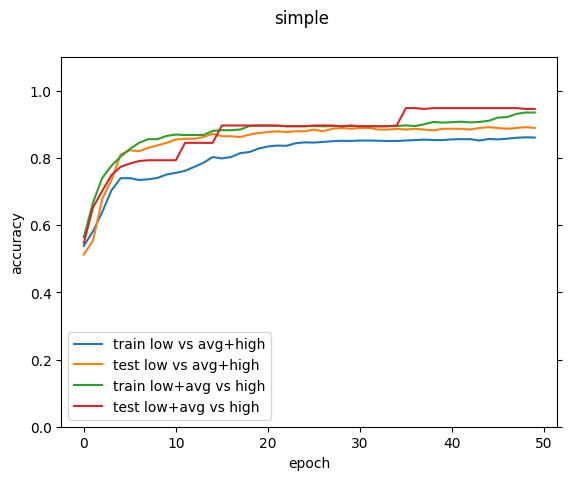

Average fraction of mistakes: simple 0.16433566433566432
Average fraction of sure decisions: simple 0.6888111888111889
Average fraction of mistakes on sure decisions: simple 0.09137055837563451


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Package Volume (cm3)', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

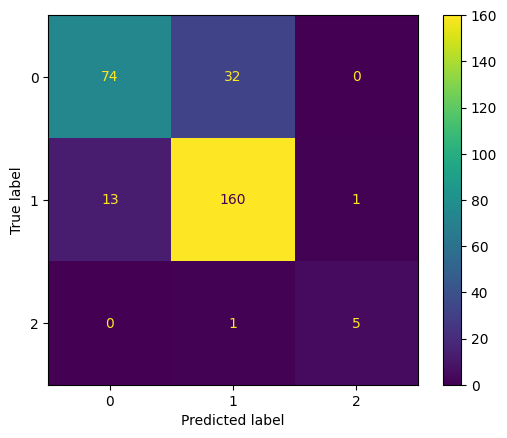

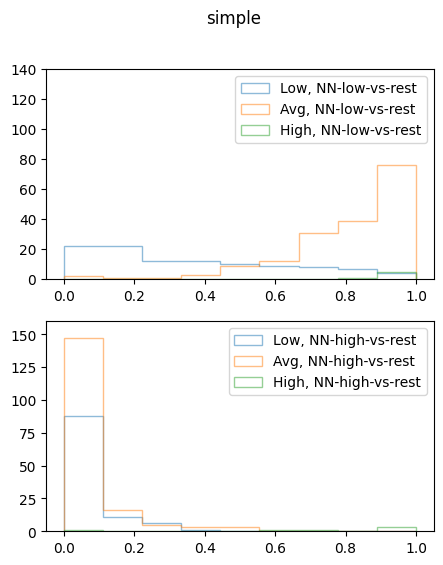

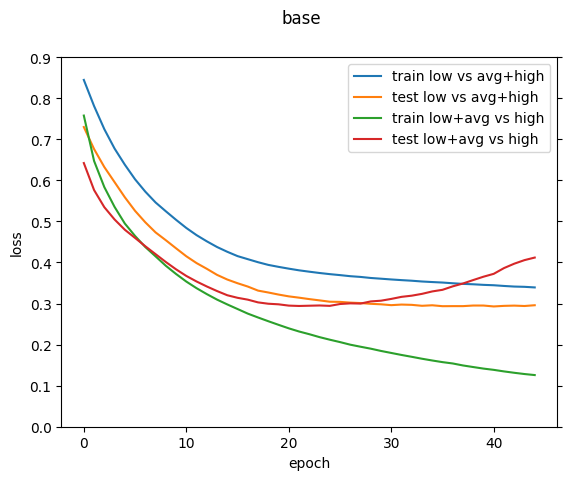

Max val accuracy 0.8866994976997375


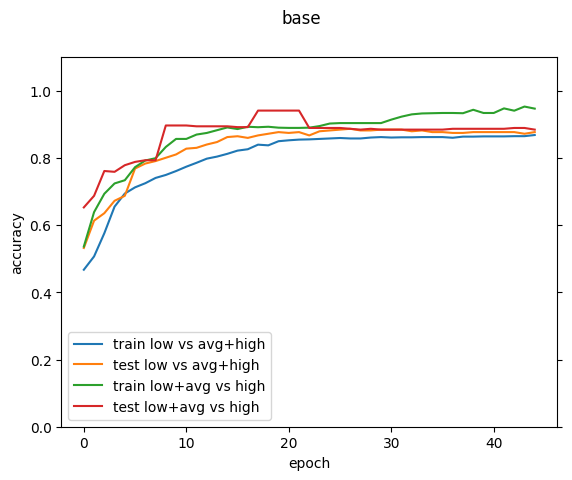

Average fraction of mistakes: base 0.1853146853146853
Average fraction of sure decisions: base 0.583916083916084
Average fraction of mistakes on sure decisions: base 0.08982035928143713


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

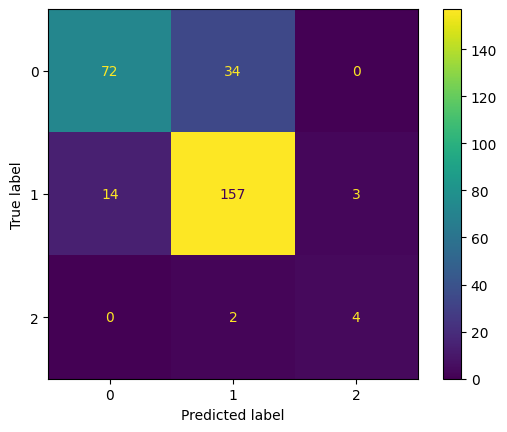

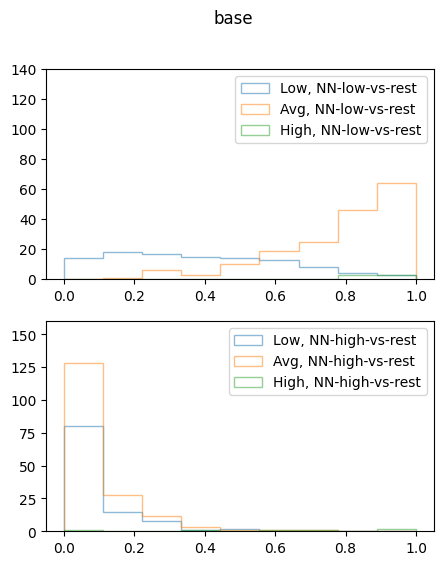

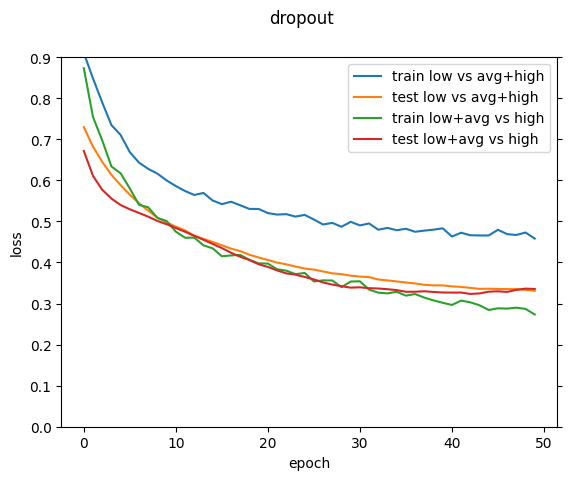

Max val accuracy 0.8645319938659668


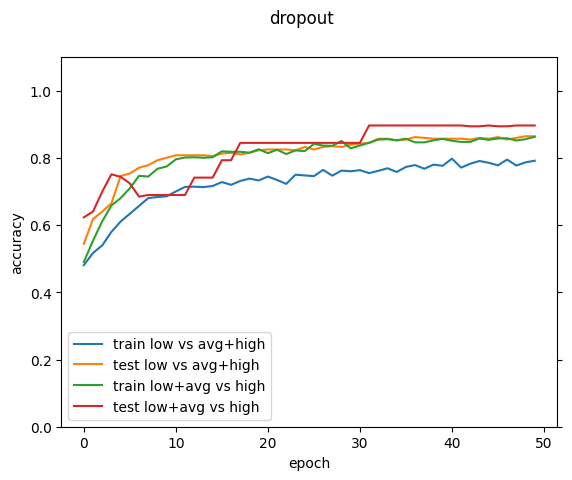

Average fraction of mistakes: dropout 0.1993006993006993
Average fraction of sure decisions: dropout 0.5524475524475524
Average fraction of mistakes on sure decisions: dropout 0.0759493670886076


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

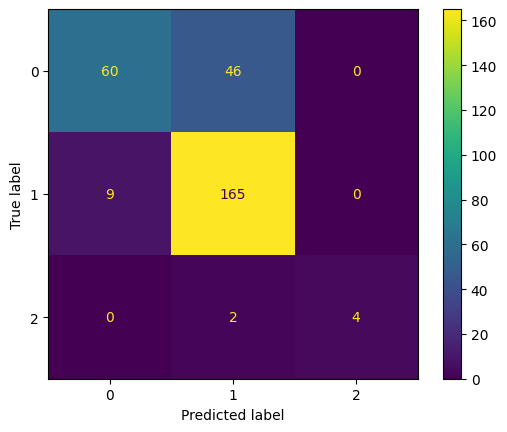

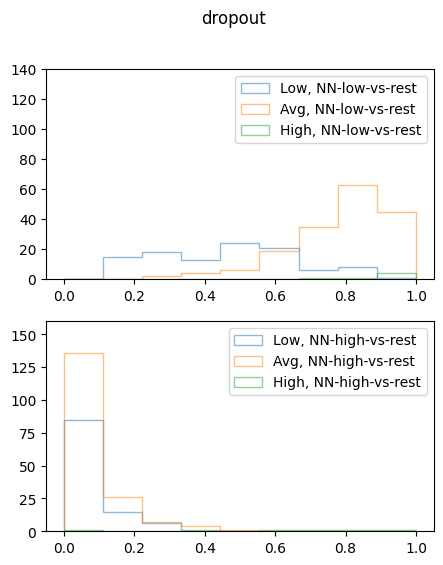

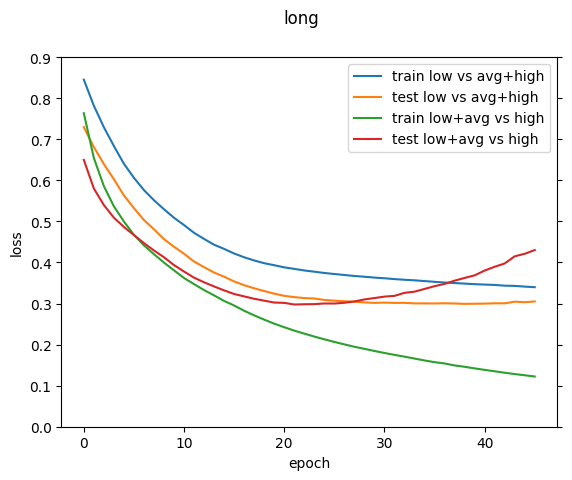

Max val accuracy 0.8842364549636841


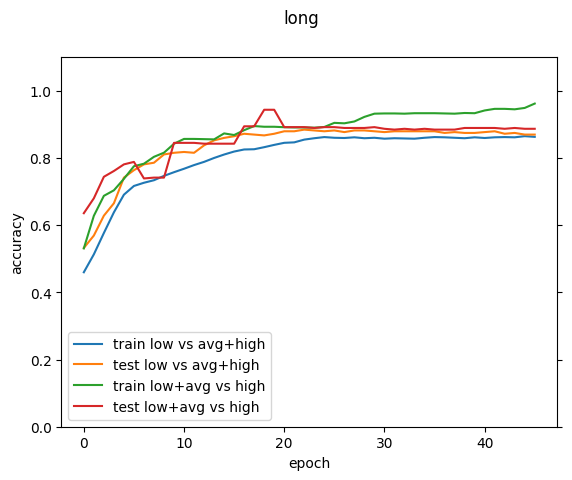

Average fraction of mistakes: long 0.18181818181818182
Average fraction of sure decisions: long 0.5804195804195804
Average fraction of mistakes on sure decisions: long 0.0783132530120482


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

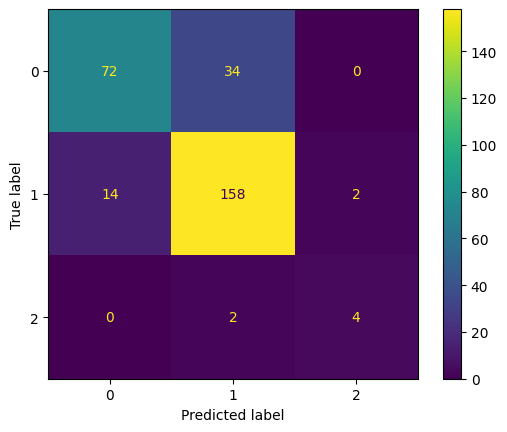

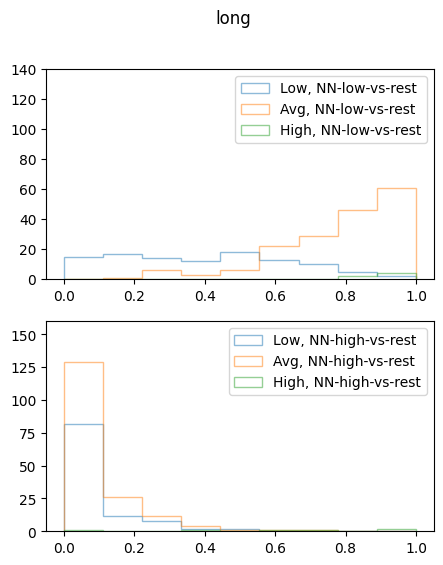

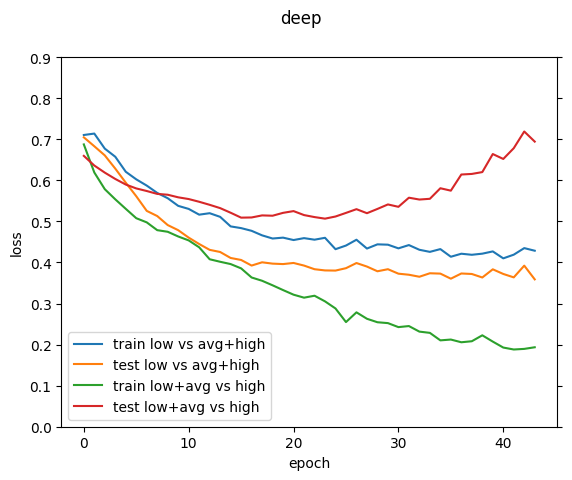

Max val accuracy 0.8522167205810547


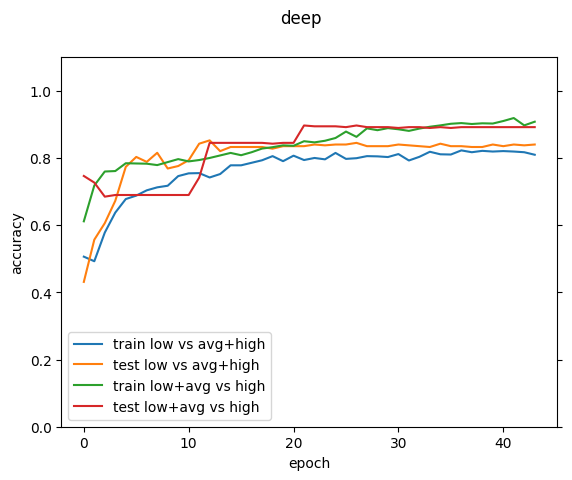

Average fraction of mistakes: deep 0.16433566433566432
Average fraction of sure decisions: deep 0.5
Average fraction of mistakes on sure decisions: deep 0.07692307692307693


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

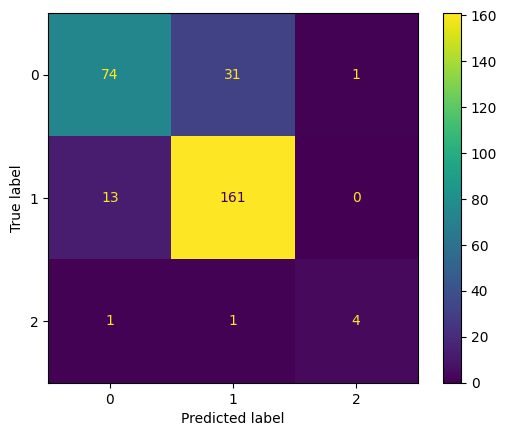

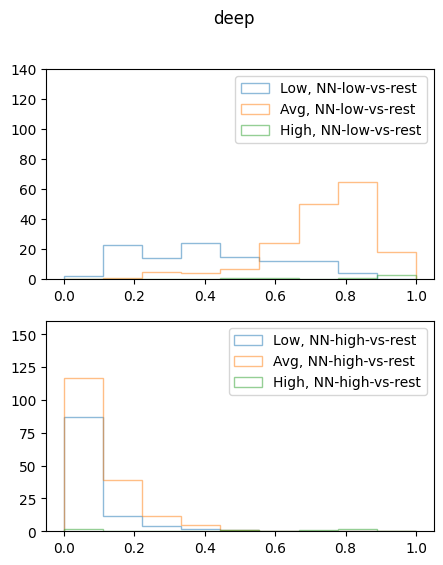

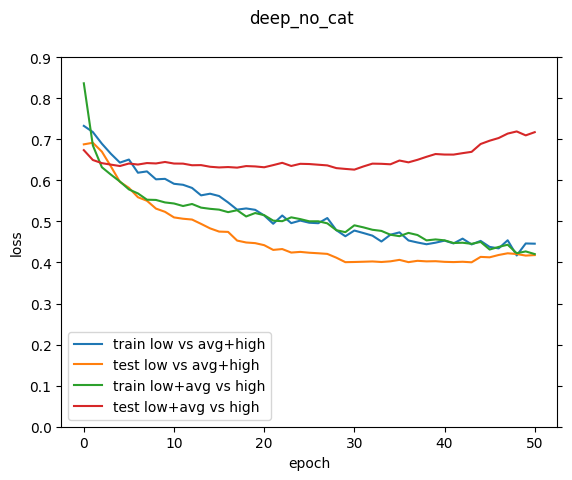

Max val accuracy 0.8325123190879822


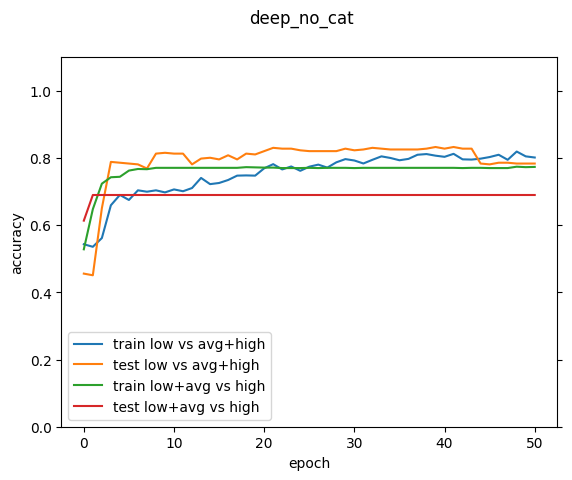

Average fraction of mistakes: deep_no_cat 0.1993006993006993
Average fraction of sure decisions: deep_no_cat 0.6468531468531469
Average fraction of mistakes on sure decisions: deep_no_cat 0.0972972972972973


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Production Recipe', 'Production Mill', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

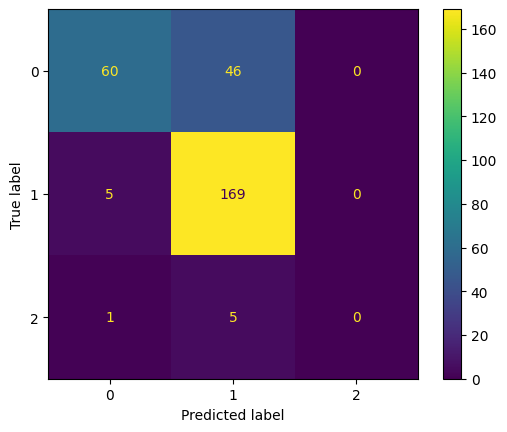

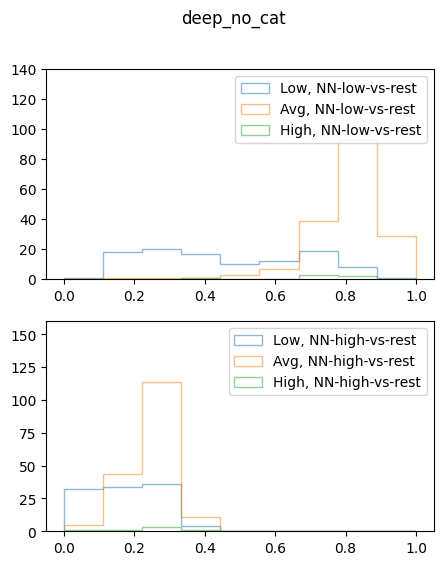

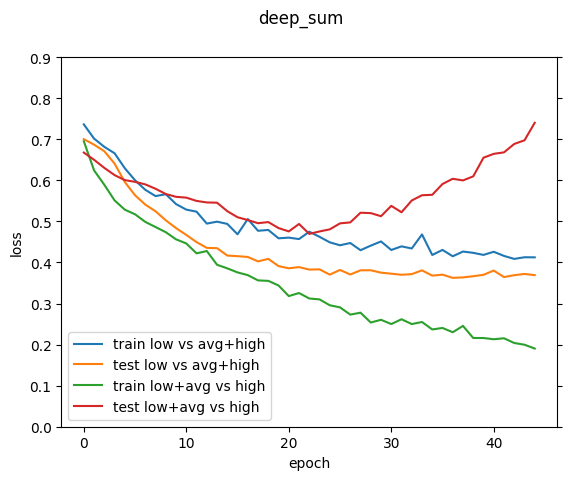

Max val accuracy 0.8916255831718445


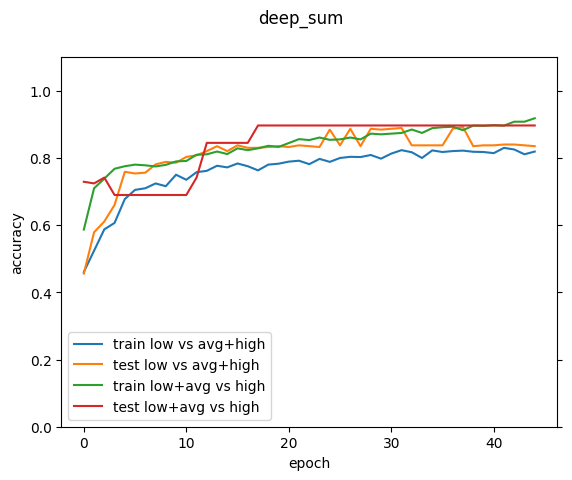

Average fraction of mistakes: deep_sum 0.17132867132867133
Average fraction of sure decisions: deep_sum 0.5034965034965035
Average fraction of mistakes on sure decisions: deep_sum 0.08333333333333333


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

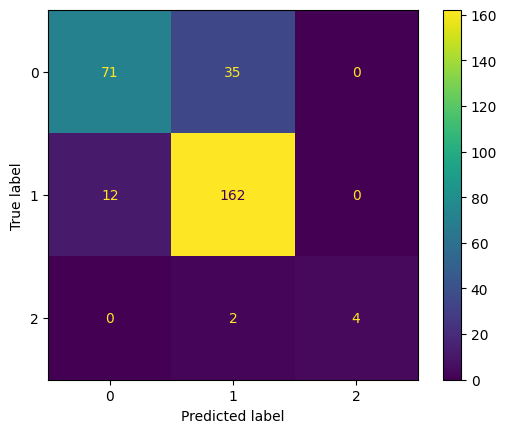

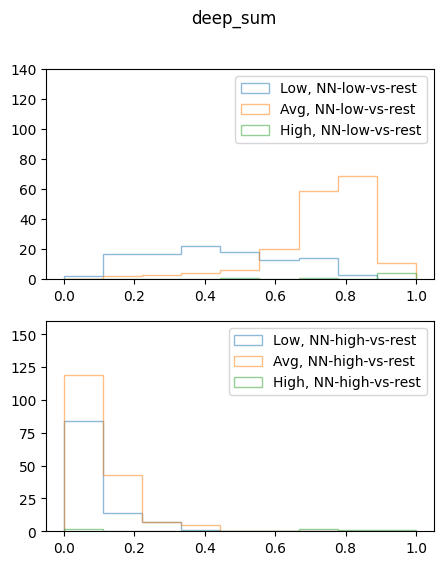

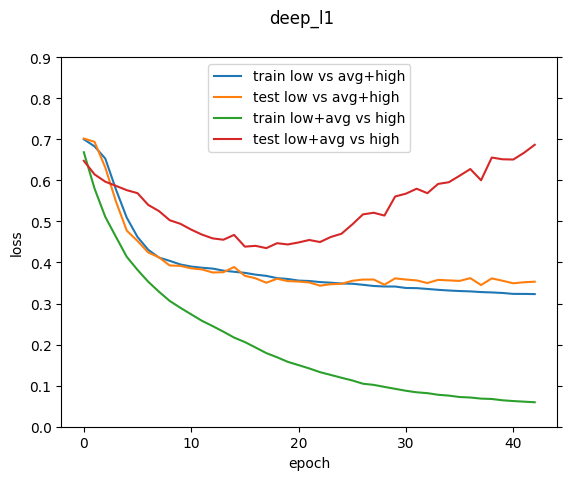

Max val accuracy 0.842364490032196


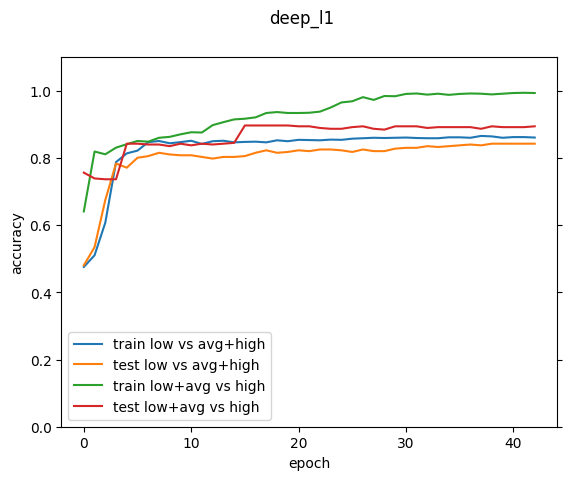

Average fraction of mistakes: deep_l1 0.19230769230769232
Average fraction of sure decisions: deep_l1 0.7027972027972028
Average fraction of mistakes on sure decisions: deep_l1 0.12935323383084577


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

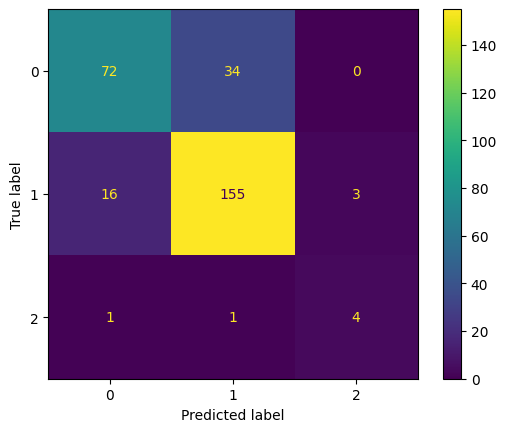

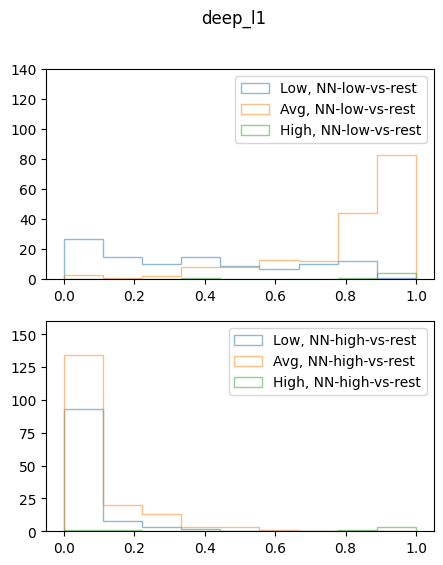

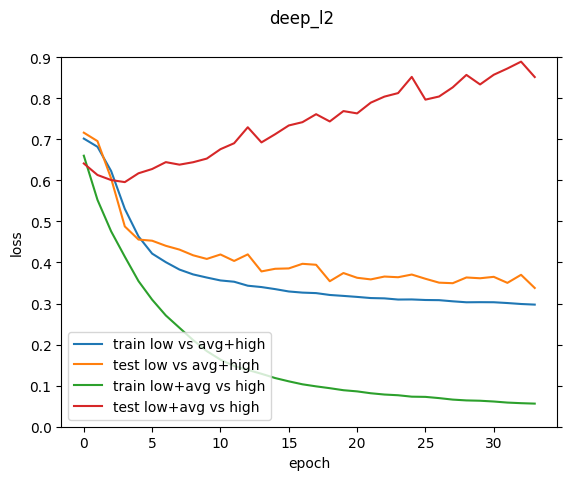

Max val accuracy 0.842364490032196


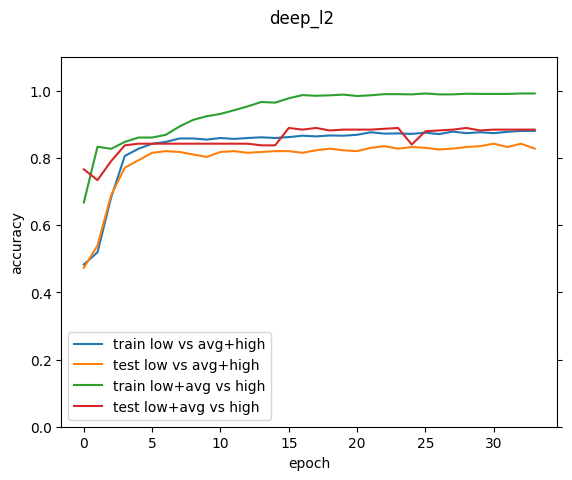

Average fraction of mistakes: deep_l2 0.20279720279720279
Average fraction of sure decisions: deep_l2 0.7097902097902098
Average fraction of mistakes on sure decisions: deep_l2 0.09852216748768473


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Package ID', 'Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

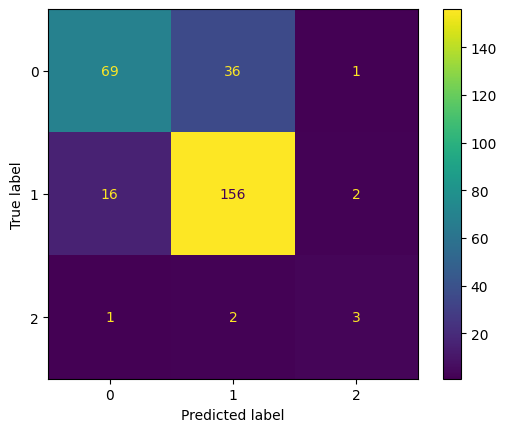

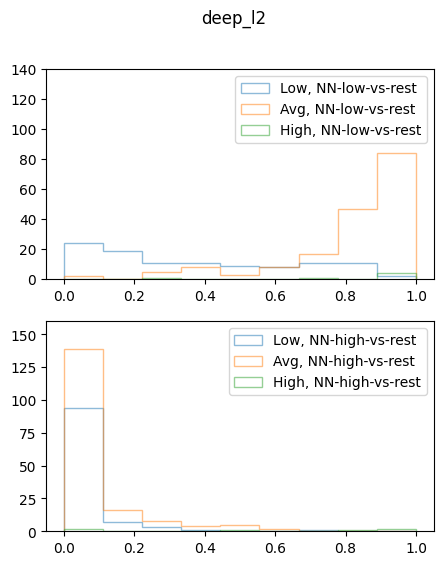

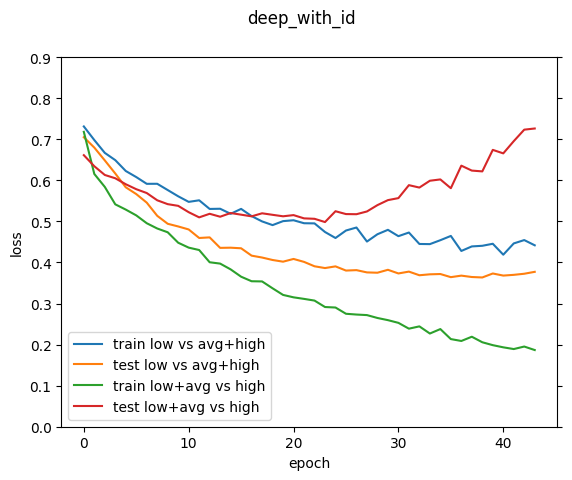

Max val accuracy 0.8694581389427185


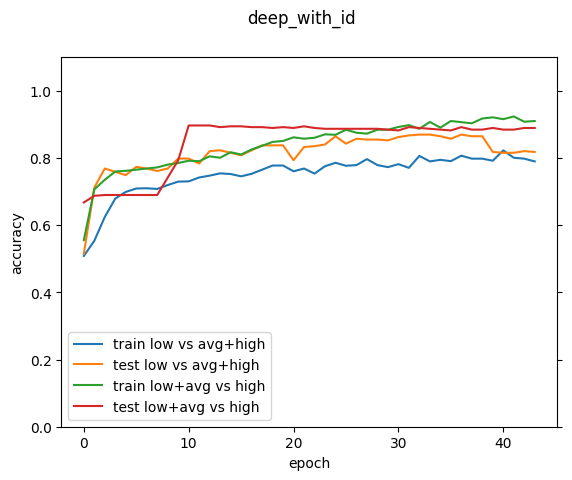

Average fraction of mistakes: deep_with_id 0.24475524475524477
Average fraction of sure decisions: deep_with_id 0.527972027972028
Average fraction of mistakes on sure decisions: deep_with_id 0.09271523178807947


/opt/homebrew/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Quality'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<Figure size 640x480 with 0 Axes>

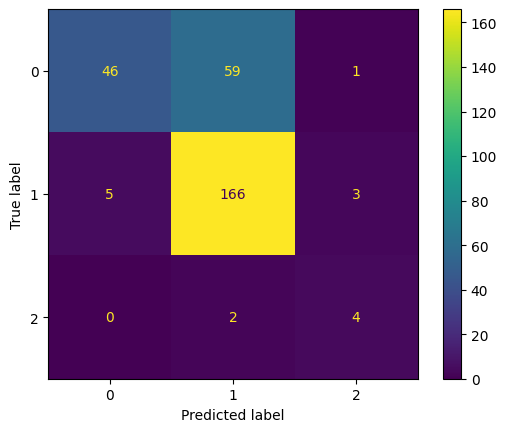

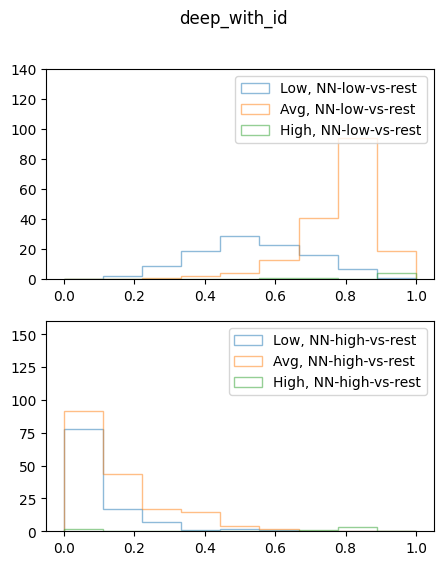

In [25]:
for name, (history, model) in histories.items():
    validation_plots(name, history, model, test_df)